In [1]:
import time
import datetime as dt
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

In [2]:
# data directory
DATA_DIR = '../../Input_processed_data'

# IC, 道路情報 csv
IC_CSV = f'{DATA_DIR}/road_master/ic_merged.csv'
IC_NET_CSV = f'{DATA_DIR}/road_master/tateyama_kannetsu_doronet_sub_with_rule.csv'

In [3]:
df = pd.read_pickle('../datasets/kannetsu_210402-220531.pkl')
df_h = pd.read_pickle('../datasets_1h/kannetsu_210402-220531.pkl')

In [11]:
rep_map = {
    '1800151': '1800146',   # 大和PA -> 六日町
    '1800072': '1800073',   # 高崎玉村スマート -> 高崎JCT
}
df.replace(rep_map, inplace=True)

In [12]:
df_ic = pd.read_csv(IC_CSV, dtype={'ic_code': str})
code2name = dict(zip(df_ic['ic_code'], df_ic['ic_name']))
name2code = {v: k for k, v in code2name.items()}

In [13]:
def get_oneday(df, date, format='%Y%m%d'):
    '''
    1日分だけdfから取得する
    '''
    cond = df['datetime'].dt.date == dt.datetime.strptime(date, format).date()
    return df.loc[cond].reset_index(drop=True)

In [14]:
def get_ic_order(df, direction):
    '''
    dfは特定道路についてのデータだと仮定して, その道路上のicの順番を得る
    '''
    def one_road_graph(df, direction):
        '''
        dfは特定道路についてのデータだと仮定して, その道路のグラフを構築する
        '''
        df_icnet = df.drop_duplicates(['start_code', 'end_code', 'direction']).reset_index(drop=True)
        df_icnet = df_icnet.loc[df_icnet['direction'] == direction]
        graph = nx.from_pandas_edgelist(df_icnet, source='start_code', target='end_code',
                                          edge_attr=['direction'],
                                          create_using=nx.DiGraph())
        return graph
    
    ic_graph = one_road_graph(df, direction)
    # グラフ上をtraverseしてICの順番を得る
    nodes = nx.dfs_postorder_nodes(ic_graph)
    nodes = list(nodes)[::-1]
    ic_order_map = {code: i for i, code in enumerate(nodes)}
    return ic_order_map

## 時間指定ありデータ

### 可視化・分析

In [9]:
df.filter(like='search').describe()

search_1h  search_unspec_1d  search_unspec_3d  search_unspec_7d  \
count  2.570400e+06      2.570400e+06      2.570400e+06      2.570400e+06   
mean   2.694932e+01      2.493667e+03      7.462371e+03      1.732661e+04   
std    5.568468e+01      1.801803e+03      5.357045e+03      1.238816e+04   
min    0.000000e+00      3.070000e+02      7.050000e+02      7.050000e+02   
25%    4.000000e+00      1.056000e+03      3.163000e+03      7.378000e+03   
50%    1.100000e+01      1.992000e+03      5.986000e+03      1.391000e+04   
75%    2.700000e+01      3.330000e+03      9.934000e+03      2.300400e+04   
max    1.455000e+03      1.279400e+04      3.373000e+04      6.919300e+04   

       search_unspec_10d  search_15min  
count       2.570400e+06  2.570400e+06  
mean        2.466160e+04  7.382154e+00  
std         1.762415e+04  1.543865e+01  
min         7.050000e+02  0.000000e+00  
25%         1.050200e+04  0.000000e+00  
50%         1.981300e+04  3.000000e+00  
75%         3.276000e+04  8.000000e+00  
max         9.069400e+04  4.590000e+02

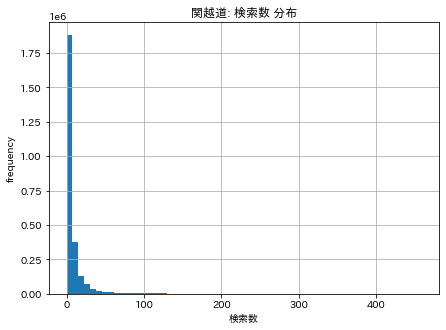

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))

ax.hist(df['search_15min'], bins=60)
ax.set_xlabel('検索数')
ax.set_ylabel('frequency')
ax.set_title('関越道: 検索数 分布')
ax.grid()

plt.show()

### 「台数」との比較

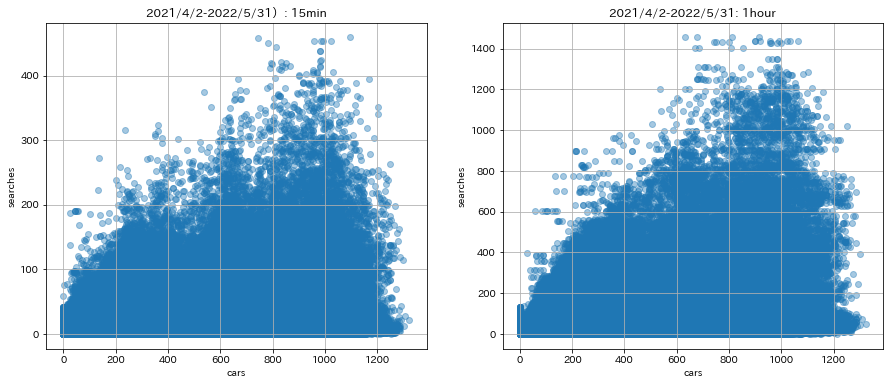

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].scatter(df['allCars'], df['search_15min'], alpha=0.4)
axes[0].set_xlabel('cars')
axes[0].set_ylabel('searches')
axes[0].set_title('2021/4/2-2022/5/31）: 15min')
axes[0].grid()

axes[1].scatter(df['allCars'], df['search_1h'], alpha=0.4)
axes[1].set_xlabel('cars')
axes[1].set_ylabel('searches')
axes[1].set_title('2021/4/2-2022/5/31: 1hour')
axes[1].grid()

plt.show()

In [16]:
up = get_ic_order(df, 0)
down = get_ic_order(df, 1)

In [17]:
print([code2name[k] for k in up.keys()])

['長岡南越路スマート', '小千谷', '越後川口', '堀之内', '小出', '六日町', '塩沢石打', '湯沢(関越道)', '水上', '月夜野', '沼田(関越道)', '昭和', '赤城', '渋川伊香保', '駒寄ＰＡ', '前橋', '高崎', '高崎ＪＣＴ', '藤岡ＪＣＴ', '上里ＳＡ', '本庄児玉', '寄居ＰＡ', '花園', '嵐山小川', '東松山', '坂戸西スマート', '鶴ヶ島', '鶴ヶ島ＪＣＴ', '川越', '三芳ＰＡ', '所沢', '大泉ＪＣＴ']


- 2021SW
- 2021/11
- 2022/1
- 2022GW

In [89]:
# start_date = '20220101'
# end_date = '20220131'
# DAYS = [d.strftime('%Y%m%d') for d in pd.date_range(start_date, end_date, freq='1D')]

# past_periods = 1
# dtypes = {'start_code': str, 'end_code': str}

# df_all = pd.DataFrame()
# for i, date in enumerate(DAYS):
#     s = time.time()
    
#     df = pd.read_csv(f'{DATA_DIR}/counts/{date}_{past_periods}d_15min.csv', dtype=dtypes, parse_dates=True, index_col='passing_time').reset_index()
#     df_all = pd.concat([df_all, df], copy=False)
    
#     print('-'*20, f'{date}: {time.time() - s} sec', '-'*20)

# df_all.reset_index(drop=True, inplace=True)

In [90]:
# df_all.to_csv(f'{DATA_DIR}/counts/202201_{past_periods}d_15min.csv', index=False)

### GW

In [94]:
df_s1 = pd.read_csv(f'{DATA_DIR}/counts/2022GW_1d_15min.csv', dtype=dtypes, parse_dates=True, index_col='passing_time').reset_index()
df_s3 = pd.read_csv(f'{DATA_DIR}/counts/2022GW_3d_15min.csv', dtype=dtypes, parse_dates=True, index_col='passing_time').reset_index()

In [98]:
start = "川越"
end = "三芳ＰＡ"

In [101]:
sub = df.query(f'start_name == "{start}"  & end_name == "{end}"')

sub1 = sub.loc[sub['datetime'] >= pd.Timestamp('2022/4/29')]\
          .loc[sub['datetime'] < pd.Timestamp('2022/5/9')]

sub2 = sub.loc[sub['datetime'] >= pd.Timestamp('2022/4/15')]\
          .loc[sub['datetime'] < pd.Timestamp('2022/4/25')]

In [102]:
df_s1 = df_s1.query(f'start_code == "{name2code[start]}"  & end_code == "{name2code[end]}"')
df_s3 = df_s3.query(f'start_code == "{name2code[start]}"  & end_code == "{name2code[end]}"')

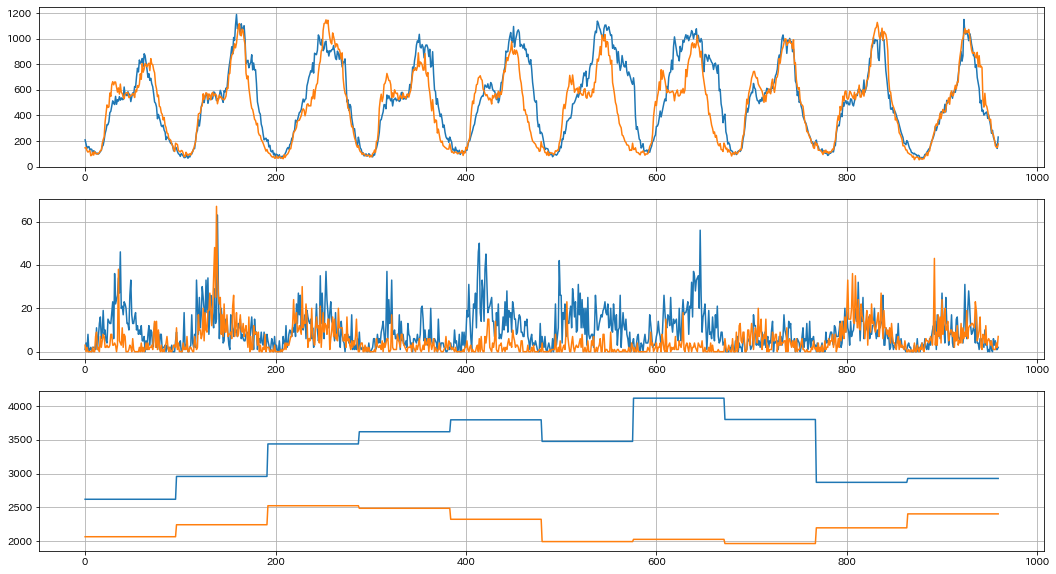

In [106]:
fig, axes = plt.subplots(3, 1, figsize=(18, 10))

xs = range(len(sub1))
ticks = range(0, len(xs), 4)
labels = list(range(24)) * (len(ticks) // 24)

axes[0].plot(xs, sub1['allCars'])
axes[0].plot(xs, sub2['allCars'])
# axes[0].set_xticks(ticks=ticks, labels=labels)
axes[0].grid()

axes[1].plot(xs, sub1['search_15min'])
axes[1].plot(xs, sub2['search_15min'])
# axes[1].set_xticks(ticks=ticks, labels=labels)
axes[1].grid()

axes[2].plot(xs, sub1['search_unspec_1d'])
axes[2].plot(xs, sub2['search_unspec_1d'])
# axes[2].set_xticks(ticks=ticks, labels=labels)
axes[2].grid()

plt.show()

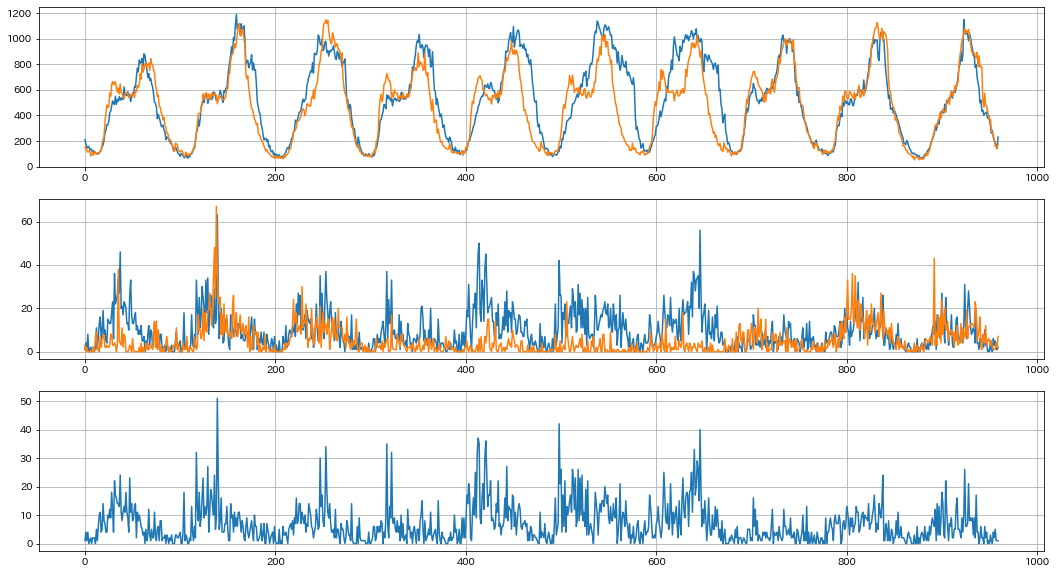

In [107]:
fig, axes = plt.subplots(3, 1, figsize=(18, 10))

xs = range(len(sub1))
ticks = range(0, len(xs), 4)
labels = list(range(24)) * (len(ticks) // 24)

axes[0].plot(xs, sub1['allCars'])
axes[0].plot(xs, sub2['allCars'])
# axes[0].set_xticks(ticks=ticks, labels=labels)
axes[0].grid()

axes[1].plot(xs, sub1['search_15min'])
axes[1].plot(xs, sub2['search_15min'])
# axes[1].set_xticks(ticks=ticks, labels=labels)
axes[1].grid()

axes[2].plot(xs, df_s3['search'])
# axes[2].set_xticks(ticks=ticks, labels=labels)
axes[2].grid()

plt.show()

In [23]:
sub = df.query(f'start_name == "{end}" & end_name == "{start}"')

sub1 = sub.loc[sub['datetime'] >= pd.Timestamp('2022/4/29')]\
          .loc[sub['datetime'] < pd.Timestamp('2022/5/9')]

sub2 = sub.loc[sub['datetime'] >= pd.Timestamp('2022/4/15')]\
          .loc[sub['datetime'] < pd.Timestamp('2022/4/25')]

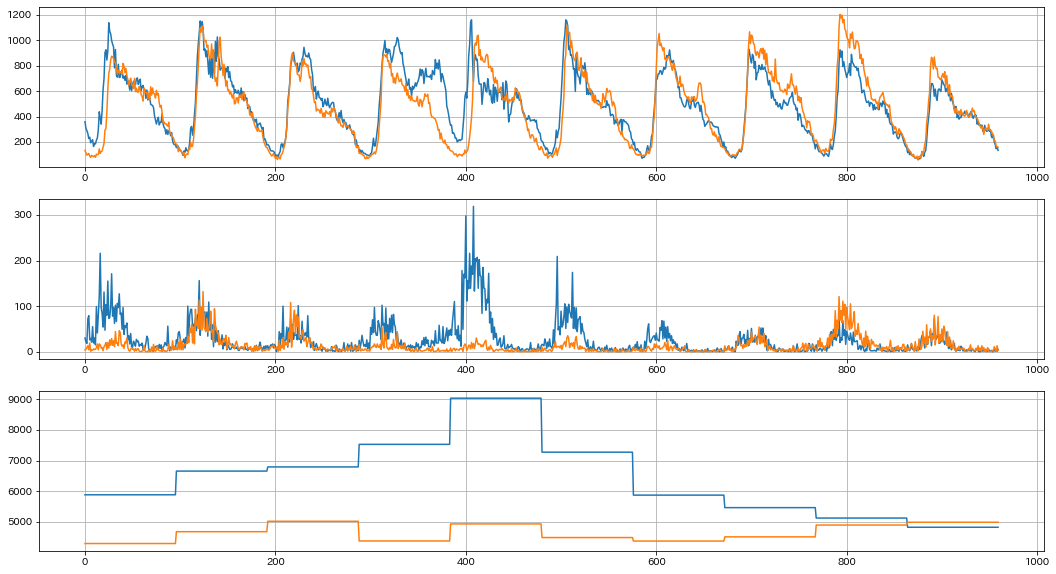

In [24]:
fig, axes = plt.subplots(3, 1, figsize=(18, 10))

xs = range(len(sub1))
ticks = range(0, len(xs), 4)
labels = list(range(24)) * (len(ticks) // 24)

axes[0].plot(xs, sub1['allCars'])
axes[0].plot(xs, sub2['allCars'])
axes[0].grid()


axes[1].plot(xs, sub1['search_15min'])
axes[1].plot(xs, sub2['search_15min'])
axes[1].grid()

axes[2].plot(xs, sub1['search_unspec_1d'])
axes[2].plot(xs, sub2['search_unspec_1d'])
axes[2].grid()

plt.show()

### 2022/5/3 vs 2022/4/26

In [103]:
start = "川越"
end = "三芳ＰＡ"

In [135]:
sub = df.query(f'start_name == "{start}"  & end_name == "{end}"')

sub1 = sub.loc[sub['datetime'] >= pd.Timestamp('2022/5/3')]\
          .loc[sub['datetime'] < pd.Timestamp('2022/5/4')]

sub2 = sub.loc[sub['datetime'] >= pd.Timestamp('2022/4/26')]\
          .loc[sub['datetime'] < pd.Timestamp('2022/4/27')]

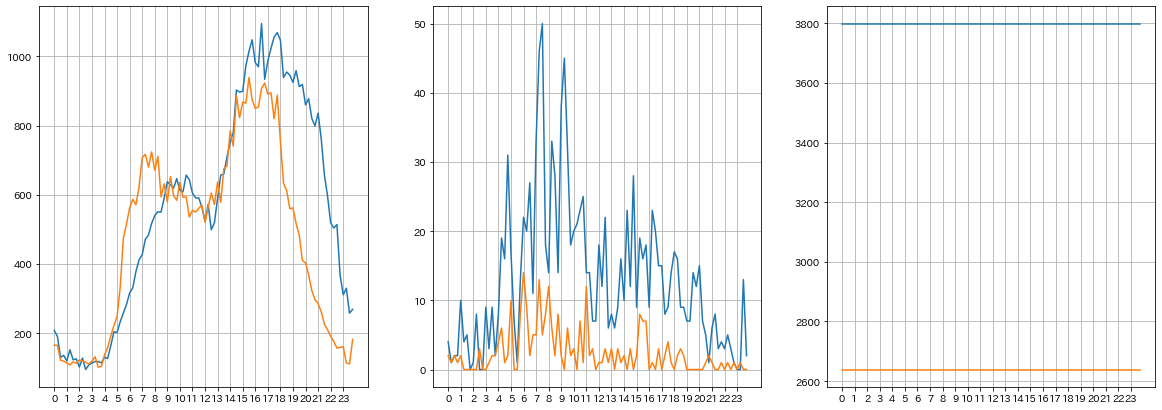

In [136]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

xs = range(len(sub1))
ticks = range(0, len(xs), 4)
labels = list(range(24)) * (len(ticks) // 24)

axes[0].plot(xs, sub1['allCars'])
axes[0].plot(xs, sub2['allCars'])
axes[0].set_xticks(ticks=ticks, labels=labels)
axes[0].grid()


axes[1].plot(xs, sub1['search_15min'])
axes[1].plot(xs, sub2['search_15min'])
axes[1].set_xticks(ticks=ticks, labels=labels)
axes[1].grid()

axes[2].plot(xs, sub1['search_unspec_1d'])
axes[2].plot(xs, sub2['search_unspec_1d'])
axes[2].set_xticks(ticks=ticks, labels=labels)
axes[2].grid()

plt.show()

In [137]:
sub = df.query(f'start_name == "{end}" & end_name == "{start}"')

sub1 = sub.loc[sub['datetime'] >= pd.Timestamp('2022/5/3')]\
          .loc[sub['datetime'] < pd.Timestamp('2022/5/4')]

sub2 = sub.loc[sub['datetime'] >= pd.Timestamp('2022/4/26')]\
          .loc[sub['datetime'] < pd.Timestamp('2022/4/27')]

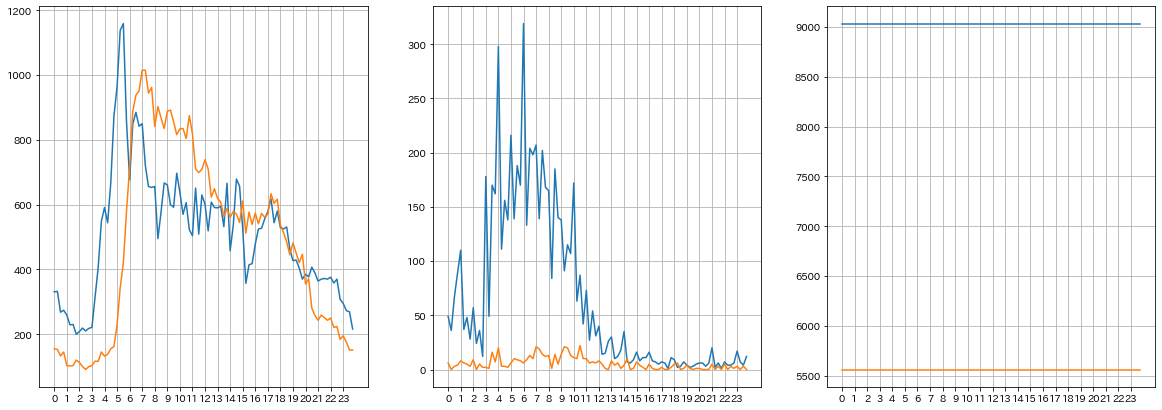

In [138]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

xs = range(len(sub1))
ticks = range(0, len(xs), 4)
labels = list(range(24)) * (len(ticks) // 24)

axes[0].plot(xs, sub1['allCars'])
axes[0].plot(xs, sub2['allCars'])
axes[0].set_xticks(ticks=ticks, labels=labels)
axes[0].grid()


axes[1].plot(xs, sub1['search_15min'])
axes[1].plot(xs, sub2['search_15min'])
axes[1].set_xticks(ticks=ticks, labels=labels)
axes[1].grid()

axes[2].plot(xs, sub1['search_unspec_1d'])
axes[2].plot(xs, sub2['search_unspec_1d'])
axes[2].set_xticks(ticks=ticks, labels=labels)
axes[2].grid()

plt.show()

### 検索を参照する日数で比較（1d vs 3d vs 7d）

#### 2022GW

In [119]:
df_s1 = pd.read_csv(f'{DATA_DIR}/counts/2022GW_1d_15min.csv', dtype=dtypes, parse_dates=True, index_col='passing_time').reset_index()
df_s3 = pd.read_csv(f'{DATA_DIR}/counts/2022GW_3d_15min.csv', dtype=dtypes, parse_dates=True, index_col='passing_time').reset_index()

In [120]:
start = "川越"
end = "三芳ＰＡ"

In [121]:
sub = df.query(f'start_name == "{start}"  & end_name == "{end}"')
sub = sub.loc[sub['datetime'] >= pd.Timestamp('2022/4/29')]\
          .loc[sub['datetime'] < pd.Timestamp('2022/5/9')]

sub_s1 = df_s1.query(f'start_code == "{name2code[start]}"  & end_code == "{name2code[end]}"')
sub_s3 = df_s3.query(f'start_code == "{name2code[start]}"  & end_code == "{name2code[end]}"')

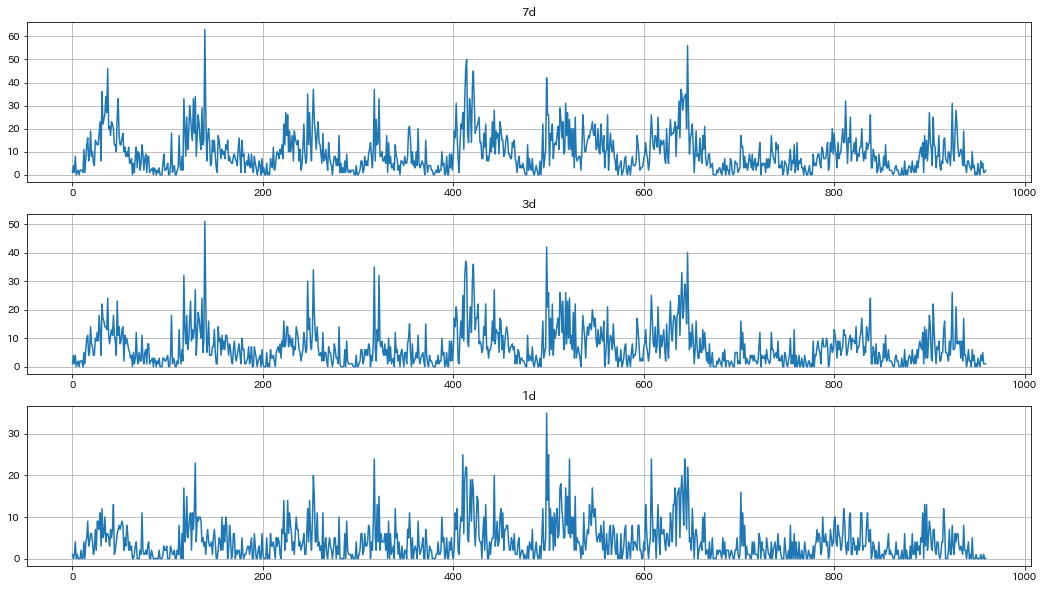

In [122]:
fig, axes = plt.subplots(3, 1, figsize=(18, 10))

xs = range(len(sub))
ticks = range(0, len(xs), 4)
labels = list(range(24)) * (len(ticks) // 24)

axes[0].plot(xs, sub['search_15min'])
# axes[0].set_xticks(ticks=ticks, labels=labels)
axes[0].set_title('7d')
axes[0].grid()

axes[1].plot(xs, sub_s3['search'])
# axes[1].set_xticks(ticks=ticks, labels=labels)
axes[1].set_title('3d')
axes[1].grid()

axes[2].plot(xs, sub_s1['search'])
# axes[2].set_xticks(ticks=ticks, labels=labels)
axes[2].set_title('1d')
axes[2].grid()

plt.show()

In [123]:
sub = df.query(f'start_name == "{end}"  & end_name == "{start}"')
sub = sub.loc[sub['datetime'] >= pd.Timestamp('2022/4/29')]\
          .loc[sub['datetime'] < pd.Timestamp('2022/5/9')]

sub_s1 = df_s1.query(f'start_code == "{name2code[end]}"  & end_code == "{name2code[start]}"')
sub_s3 = df_s3.query(f'start_code == "{name2code[end]}"  & end_code == "{name2code[start]}"')

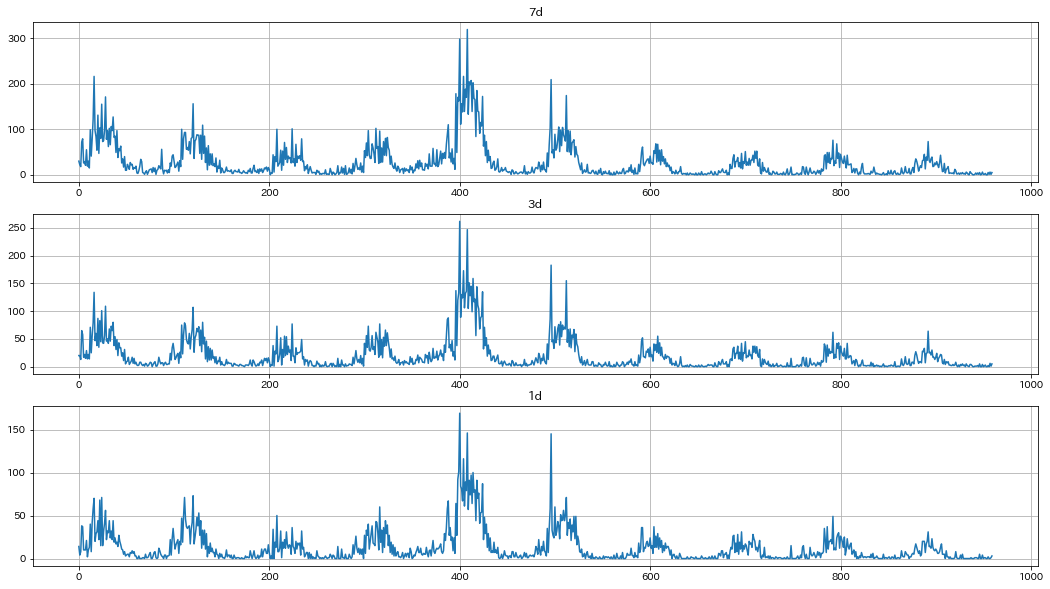

In [124]:
fig, axes = plt.subplots(3, 1, figsize=(18, 10))

xs = range(len(sub))
ticks = range(0, len(xs), 4)
labels = list(range(24)) * (len(ticks) // 24)

axes[0].plot(xs, sub['search_15min'])
# axes[0].set_xticks(ticks=ticks, labels=labels)
axes[0].set_title('7d')
axes[0].grid()

axes[1].plot(xs, sub_s3['search'])
# axes[1].set_xticks(ticks=ticks, labels=labels)
axes[1].set_title('3d')
axes[1].grid()

axes[2].plot(xs, sub_s1['search'])
# axes[2].set_xticks(ticks=ticks, labels=labels)
axes[2].set_title('1d')
axes[2].grid()

plt.show()

#### 2022/1

In [244]:
df_s1 = pd.read_csv(f'{DATA_DIR}/counts/202201_1d_15min.csv', dtype=dtypes, parse_dates=True, index_col='passing_time').reset_index()
df_s3 = pd.read_csv(f'{DATA_DIR}/counts/202201_3d_15min.csv', dtype=dtypes, parse_dates=True, index_col='passing_time').reset_index()

In [245]:
df_s1 = df_s1.set_index('passing_time').groupby(['start_code', 'end_code'])\
            .apply(lambda g: g.reindex(pd.date_range(start=df_s1.passing_time.min(), end=df_s1.passing_time.max(), freq='15min')).fillna(0))\
            .search\
            .reset_index()

df_s3 = df_s3.set_index('passing_time').groupby(['start_code', 'end_code'])\
            .apply(lambda g: g.reindex(pd.date_range(start=df_s3.passing_time.min(), end=df_s3.passing_time.max(), freq='15min')).fillna(0))\
            .search\
            .reset_index()

In [246]:
start = "川越"
end = "三芳ＰＡ"

In [247]:
sub = df.query(f'start_name == "{start}"  & end_name == "{end}"')
sub = sub.loc[sub['datetime'] >= pd.Timestamp('2022/1/1')]\
          .loc[sub['datetime'] < pd.Timestamp('2022/2/1')]

sub_s1 = df_s1.query(f'start_code == "{name2code[start]}"  & end_code == "{name2code[end]}"')
sub_s3 = df_s3.query(f'start_code == "{name2code[start]}"  & end_code == "{name2code[end]}"')

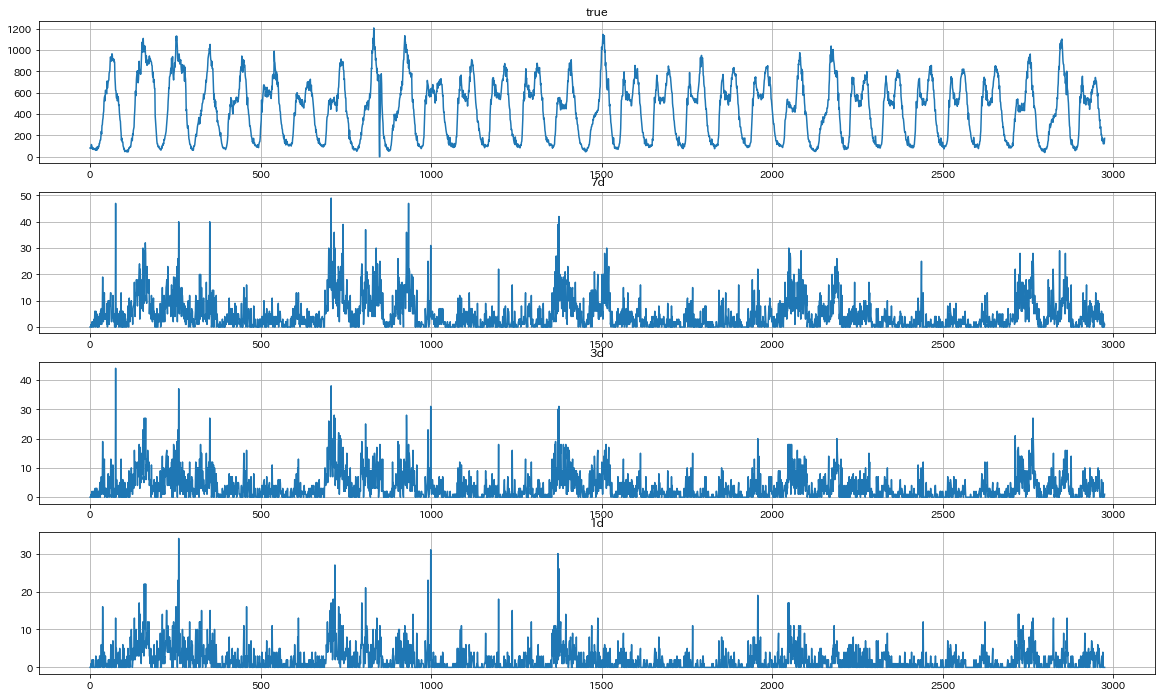

In [248]:
fig, axes = plt.subplots(4, 1, figsize=(20, 12))

xs = range(len(sub))
ticks = range(0, len(xs), 4)
labels = list(range(24)) * (len(ticks) // 24)

axes[0].plot(xs, sub['allCars'])
# axes[0].set_xticks(ticks=ticks, labels=labels)
axes[0].set_title('true')
axes[0].grid()

axes[1].plot(xs, sub['search_15min'])
# axes[0].set_xticks(ticks=ticks, labels=labels)
axes[1].set_title('7d')
axes[1].grid()

axes[2].plot(xs, sub_s3['search'])
# axes[1].set_xticks(ticks=ticks, labels=labels)
axes[2].set_title('3d')
axes[2].grid()

axes[3].plot(xs, sub_s1['search'])
# axes[2].set_xticks(ticks=ticks, labels=labels)
axes[3].set_title('1d')
axes[3].grid()

plt.show()

In [249]:
sub = df.query(f'start_name == "{end}"  & end_name == "{start}"')
sub = sub.loc[sub['datetime'] >= pd.Timestamp('2022/1/1')]\
          .loc[sub['datetime'] < pd.Timestamp('2022/2/1')]

sub_s1 = df_s1.query(f'start_code == "{name2code[end]}"  & end_code == "{name2code[start]}"')
sub_s3 = df_s3.query(f'start_code == "{name2code[end]}"  & end_code == "{name2code[start]}"')

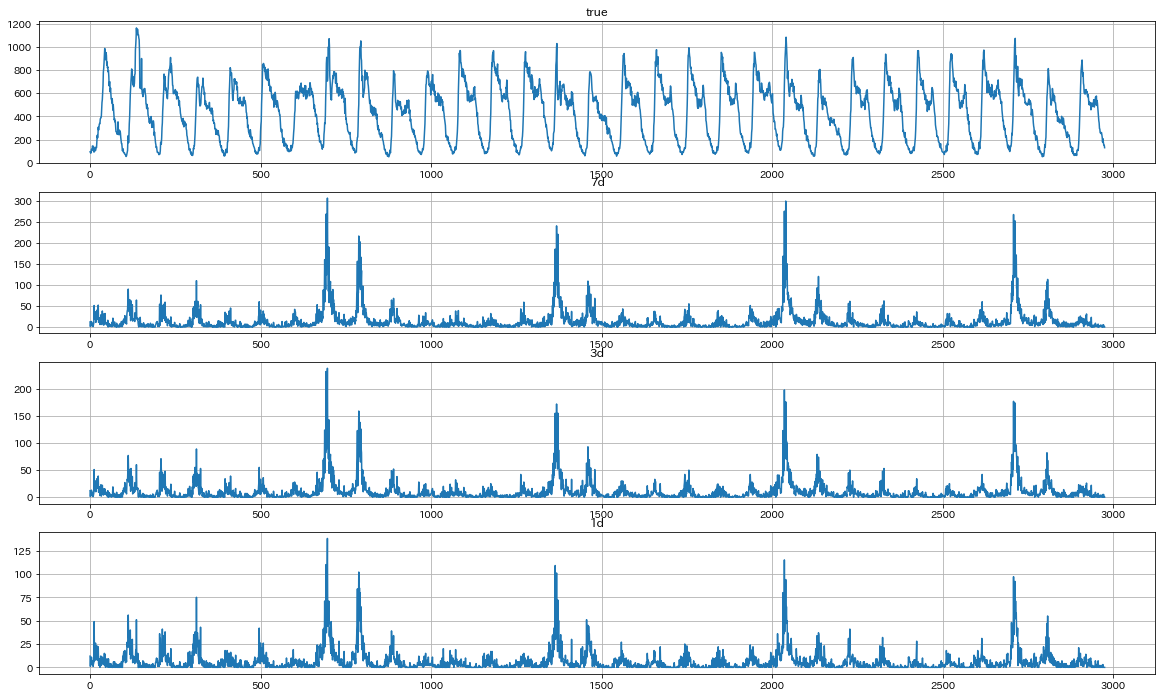

In [250]:
fig, axes = plt.subplots(4, 1, figsize=(20, 12))

xs = range(len(sub))
ticks = range(0, len(xs), 4)
labels = list(range(24)) * (len(ticks) // 24)

axes[0].plot(xs, sub['allCars'])
# axes[0].set_xticks(ticks=ticks, labels=labels)
axes[0].set_title('true')
axes[0].grid()

axes[1].plot(xs, sub['search_15min'])
# axes[0].set_xticks(ticks=ticks, labels=labels)
axes[1].set_title('7d')
axes[1].grid()

axes[2].plot(xs, sub_s3['search'])
# axes[1].set_xticks(ticks=ticks, labels=labels)
axes[2].set_title('3d')
axes[2].grid()

axes[3].plot(xs, sub_s1['search'])
# axes[2].set_xticks(ticks=ticks, labels=labels)
axes[3].set_title('1d')
axes[3].grid()

plt.show()

In [251]:
start = "小出"
end = "大和ＰＡ"

In [252]:
sub = df.query(f'start_name == "{start}"  & end_name == "{end}"')
sub = sub.loc[sub['datetime'] >= pd.Timestamp('2022/1/1')]\
          .loc[sub['datetime'] < pd.Timestamp('2022/2/1')]

sub_s1 = df_s1.query(f'start_code == "{name2code[start]}"  & end_code == "{name2code[end]}"')
sub_s3 = df_s3.query(f'start_code == "{name2code[start]}"  & end_code == "{name2code[end]}"')

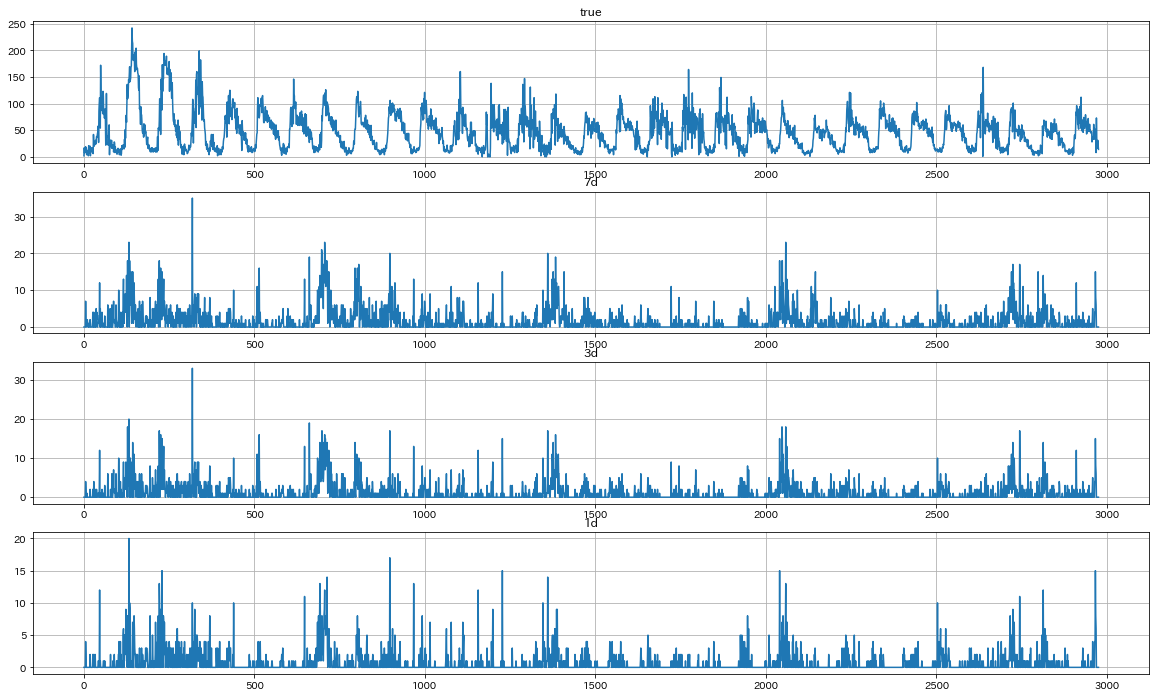

In [253]:
fig, axes = plt.subplots(4, 1, figsize=(20, 12))

xs = range(len(sub))
ticks = range(0, len(xs), 4)
labels = list(range(24)) * (len(ticks) // 24)

axes[0].plot(xs, sub['allCars'])
# axes[0].set_xticks(ticks=ticks, labels=labels)
axes[0].set_title('true')
axes[0].grid()

axes[1].plot(xs, sub['search_15min'])
# axes[0].set_xticks(ticks=ticks, labels=labels)
axes[1].set_title('7d')
axes[1].grid()

axes[2].plot(xs, sub_s3['search'])
# axes[1].set_xticks(ticks=ticks, labels=labels)
axes[2].set_title('3d')
axes[2].grid()

axes[3].plot(xs, sub_s1['search'])
# axes[2].set_xticks(ticks=ticks, labels=labels)
axes[3].set_title('1d')
axes[3].grid()

plt.show()

In [254]:
sub = df.query(f'start_name == "{end}"  & end_name == "{start}"')
sub = sub.loc[sub['datetime'] >= pd.Timestamp('2022/1/1')]\
          .loc[sub['datetime'] < pd.Timestamp('2022/2/1')]

sub_s1 = df_s1.query(f'start_code == "{name2code[end]}"  & end_code == "{name2code[start]}"')
sub_s3 = df_s3.query(f'start_code == "{name2code[end]}"  & end_code == "{name2code[start]}"')

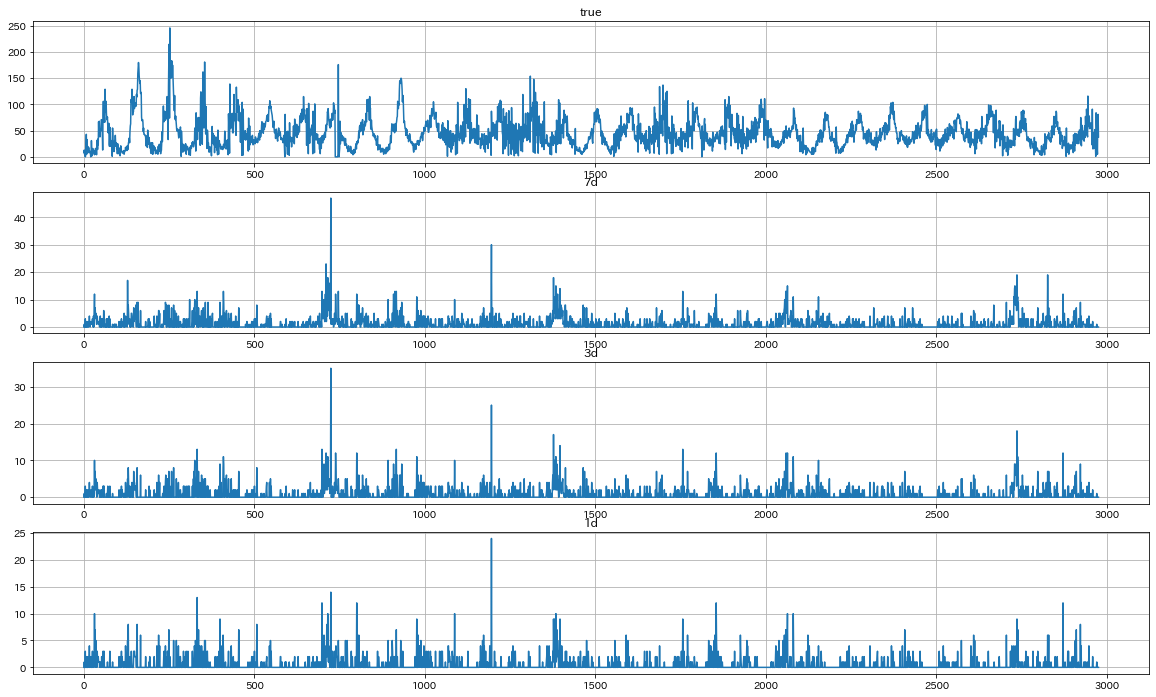

In [255]:
fig, axes = plt.subplots(4, 1, figsize=(20, 12))

xs = range(len(sub))
ticks = range(0, len(xs), 4)
labels = list(range(24)) * (len(ticks) // 24)

axes[0].plot(xs, sub['allCars'])
# axes[0].set_xticks(ticks=ticks, labels=labels)
axes[0].set_title('true')
axes[0].grid()

axes[1].plot(xs, sub['search_15min'])
# axes[0].set_xticks(ticks=ticks, labels=labels)
axes[1].set_title('7d')
axes[1].grid()

axes[2].plot(xs, sub_s3['search'])
# axes[1].set_xticks(ticks=ticks, labels=labels)
axes[2].set_title('3d')
axes[2].grid()

axes[3].plot(xs, sub_s1['search'])
# axes[2].set_xticks(ticks=ticks, labels=labels)
axes[3].set_title('1d')
axes[3].grid()

plt.show()

#### 2021/11

In [194]:
df_s1 = pd.read_csv(f'{DATA_DIR}/counts/202111_1d_15min.csv', dtype=dtypes, parse_dates=True, index_col='passing_time').reset_index()
df_s3 = pd.read_csv(f'{DATA_DIR}/counts/202111_3d_15min.csv', dtype=dtypes, parse_dates=True, index_col='passing_time').reset_index()

In [195]:
df_s1 = df_s1.set_index('passing_time').groupby(['start_code', 'end_code'])\
            .apply(lambda g: g.reindex(pd.date_range(start=df_s1.passing_time.min(), end=df_s1.passing_time.max(), freq='15min')).fillna(0))\
            .search\
            .reset_index()

df_s3 = df_s3.set_index('passing_time').groupby(['start_code', 'end_code'])\
            .apply(lambda g: g.reindex(pd.date_range(start=df_s3.passing_time.min(), end=df_s3.passing_time.max(), freq='15min')).fillna(0))\
            .search\
            .reset_index()

In [196]:
start = "川越"
end = "三芳ＰＡ"

In [197]:
sub = df.query(f'start_name == "{start}"  & end_name == "{end}"')
sub = sub.loc[sub['datetime'] >= pd.Timestamp('2021/11/1')]\
          .loc[sub['datetime'] < pd.Timestamp('2021/12/1')]

sub_s1 = df_s1.query(f'start_code == "{name2code[start]}"  & end_code == "{name2code[end]}"')
sub_s3 = df_s3.query(f'start_code == "{name2code[start]}"  & end_code == "{name2code[end]}"')

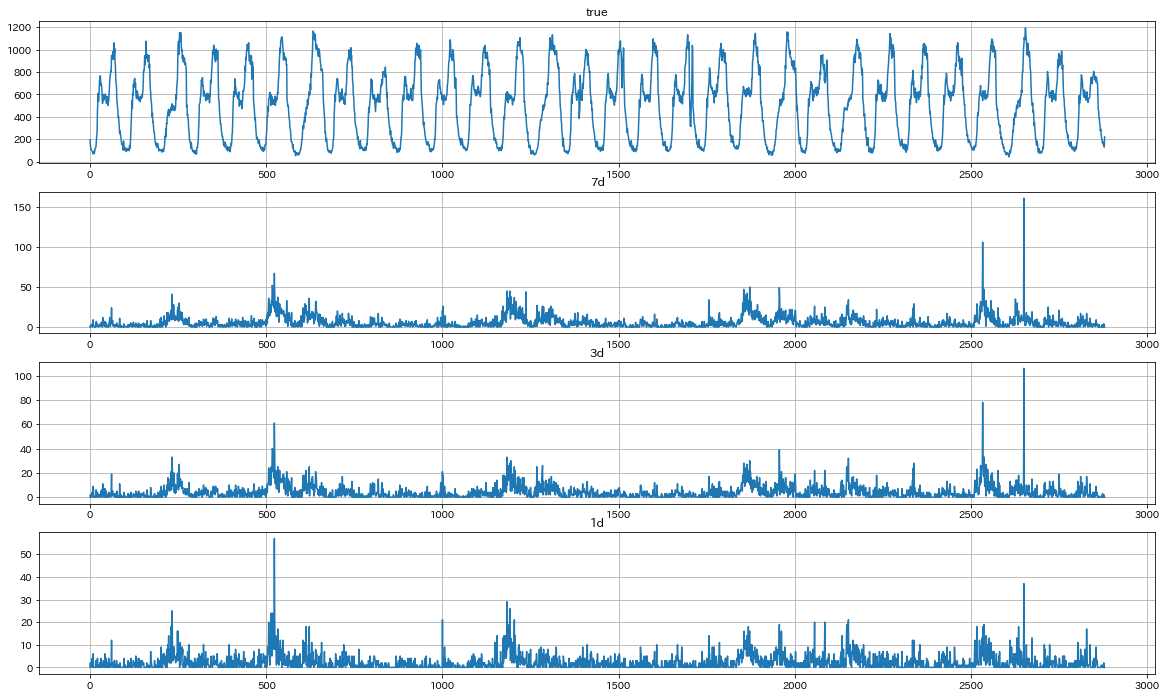

In [198]:
fig, axes = plt.subplots(4, 1, figsize=(20, 12))

xs = range(len(sub))
ticks = range(0, len(xs), 4)
labels = list(range(24)) * (len(ticks) // 24)

axes[0].plot(xs, sub['allCars'])
# axes[0].set_xticks(ticks=ticks, labels=labels)
axes[0].set_title('true')
axes[0].grid()

axes[1].plot(xs, sub['search_15min'])
# axes[0].set_xticks(ticks=ticks, labels=labels)
axes[1].set_title('7d')
axes[1].grid()

axes[2].plot(xs, sub_s3['search'])
# axes[1].set_xticks(ticks=ticks, labels=labels)
axes[2].set_title('3d')
axes[2].grid()

axes[3].plot(xs, sub_s1['search'])
# axes[2].set_xticks(ticks=ticks, labels=labels)
axes[3].set_title('1d')
axes[3].grid()

plt.show()

In [199]:
sub = df.query(f'start_name == "{end}"  & end_name == "{start}"')
sub = sub.loc[sub['datetime'] >= pd.Timestamp('2021/11/1')]\
          .loc[sub['datetime'] < pd.Timestamp('2021/12/1')]

sub_s1 = df_s1.query(f'start_code == "{name2code[end]}"  & end_code == "{name2code[start]}"')
sub_s3 = df_s3.query(f'start_code == "{name2code[end]}"  & end_code == "{name2code[start]}"')

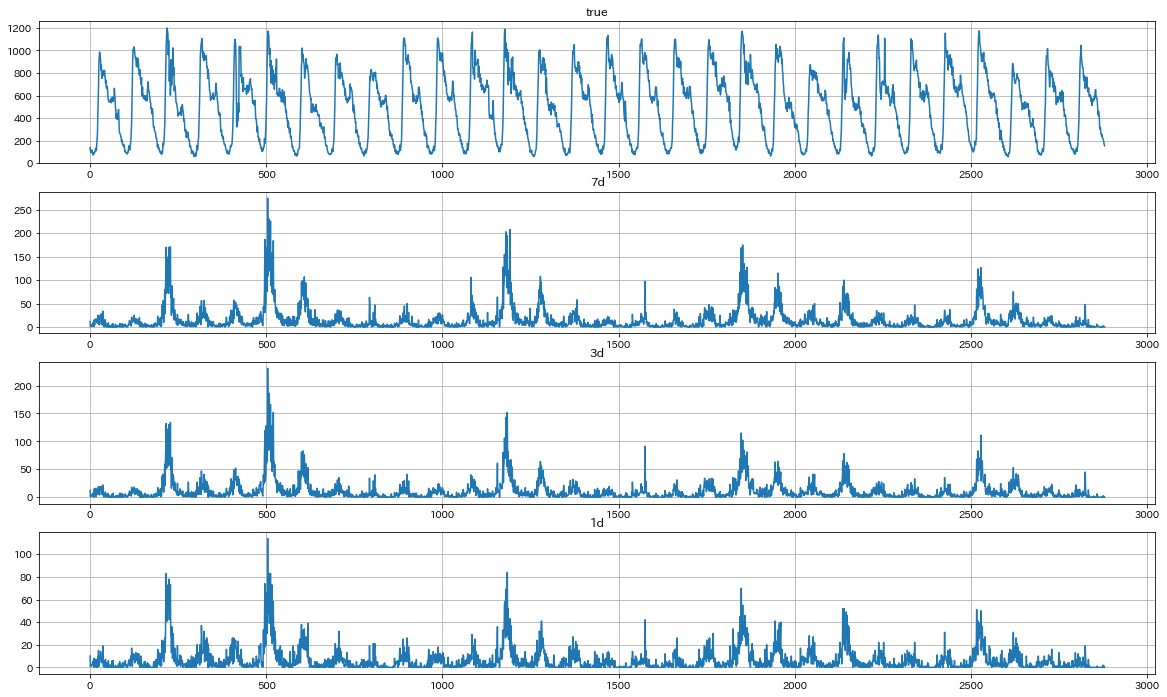

In [200]:
fig, axes = plt.subplots(4, 1, figsize=(20, 12))

xs = range(len(sub))
ticks = range(0, len(xs), 4)
labels = list(range(24)) * (len(ticks) // 24)

axes[0].plot(xs, sub['allCars'])
# axes[0].set_xticks(ticks=ticks, labels=labels)
axes[0].set_title('true')
axes[0].grid()

axes[1].plot(xs, sub['search_15min'])
# axes[0].set_xticks(ticks=ticks, labels=labels)
axes[1].set_title('7d')
axes[1].grid()

axes[2].plot(xs, sub_s3['search'])
# axes[1].set_xticks(ticks=ticks, labels=labels)
axes[2].set_title('3d')
axes[2].grid()

axes[3].plot(xs, sub_s1['search'])
# axes[2].set_xticks(ticks=ticks, labels=labels)
axes[3].set_title('1d')
axes[3].grid()

plt.show()

#### 2021SW

In [201]:
df_s1 = pd.read_csv(f'{DATA_DIR}/counts/2021SW_1d_15min.csv', dtype=dtypes, parse_dates=True, index_col='passing_time').reset_index()
df_s3 = pd.read_csv(f'{DATA_DIR}/counts/2021SW_3d_15min.csv', dtype=dtypes, parse_dates=True, index_col='passing_time').reset_index()

In [202]:
df_s1 = df_s1.set_index('passing_time').groupby(['start_code', 'end_code'])\
            .apply(lambda g: g.reindex(pd.date_range(start=df_s1.passing_time.min(), end=df_s1.passing_time.max(), freq='15min')).fillna(0))\
            .search\
            .reset_index()

df_s3 = df_s3.set_index('passing_time').groupby(['start_code', 'end_code'])\
            .apply(lambda g: g.reindex(pd.date_range(start=df_s3.passing_time.min(), end=df_s3.passing_time.max(), freq='15min')).fillna(0))\
            .search\
            .reset_index()

In [203]:
start = "川越"
end = "三芳ＰＡ"

In [204]:
sub = df.query(f'start_name == "{start}"  & end_name == "{end}"')
sub = sub.loc[sub['datetime'] >= pd.Timestamp('2021/9/18')]\
          .loc[sub['datetime'] < pd.Timestamp('2021/9/24')]

sub_s1 = df_s1.query(f'start_code == "{name2code[start]}"  & end_code == "{name2code[end]}"')
sub_s3 = df_s3.query(f'start_code == "{name2code[start]}"  & end_code == "{name2code[end]}"')

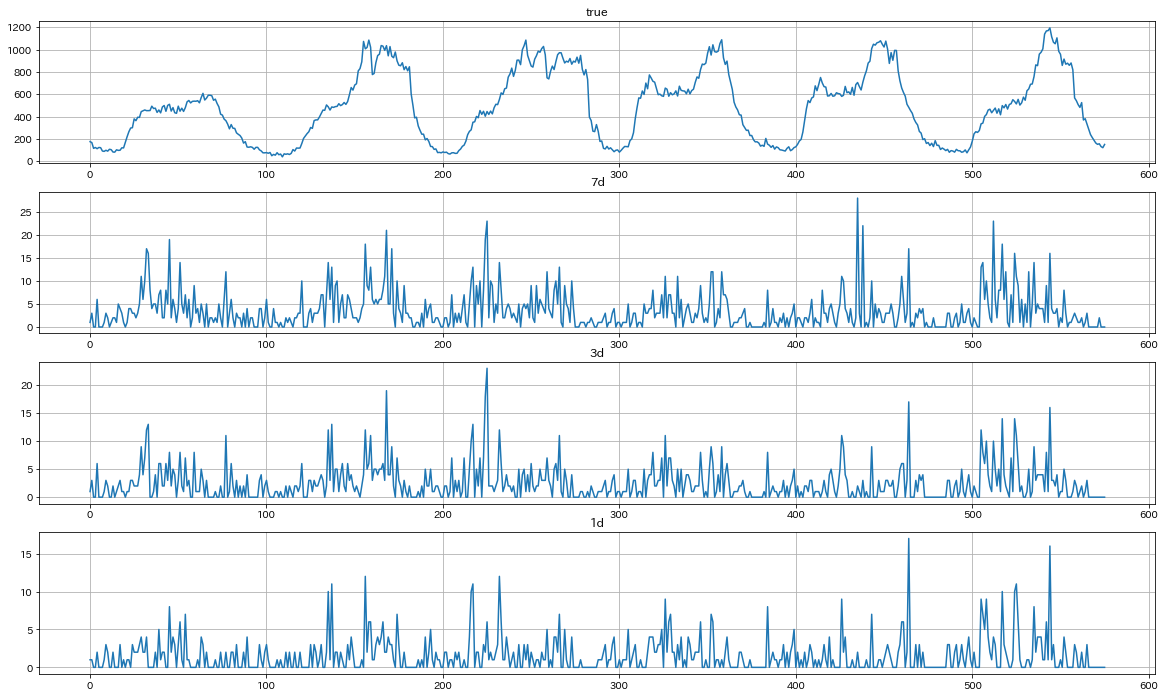

In [205]:
fig, axes = plt.subplots(4, 1, figsize=(20, 12))

xs = range(len(sub))
ticks = range(0, len(xs), 4)
labels = list(range(24)) * (len(ticks) // 24)

axes[0].plot(xs, sub['allCars'])
# axes[0].set_xticks(ticks=ticks, labels=labels)
axes[0].set_title('true')
axes[0].grid()

axes[1].plot(xs, sub['search_15min'])
# axes[0].set_xticks(ticks=ticks, labels=labels)
axes[1].set_title('7d')
axes[1].grid()

axes[2].plot(xs, sub_s3['search'])
# axes[1].set_xticks(ticks=ticks, labels=labels)
axes[2].set_title('3d')
axes[2].grid()

axes[3].plot(xs, sub_s1['search'])
# axes[2].set_xticks(ticks=ticks, labels=labels)
axes[3].set_title('1d')
axes[3].grid()

plt.show()

In [206]:
sub = df.query(f'start_name == "{end}"  & end_name == "{start}"')
sub = sub.loc[sub['datetime'] >= pd.Timestamp('2021/9/18')]\
          .loc[sub['datetime'] < pd.Timestamp('2021/9/24')]

sub_s1 = df_s1.query(f'start_code == "{name2code[end]}"  & end_code == "{name2code[start]}"')
sub_s3 = df_s3.query(f'start_code == "{name2code[end]}"  & end_code == "{name2code[start]}"')

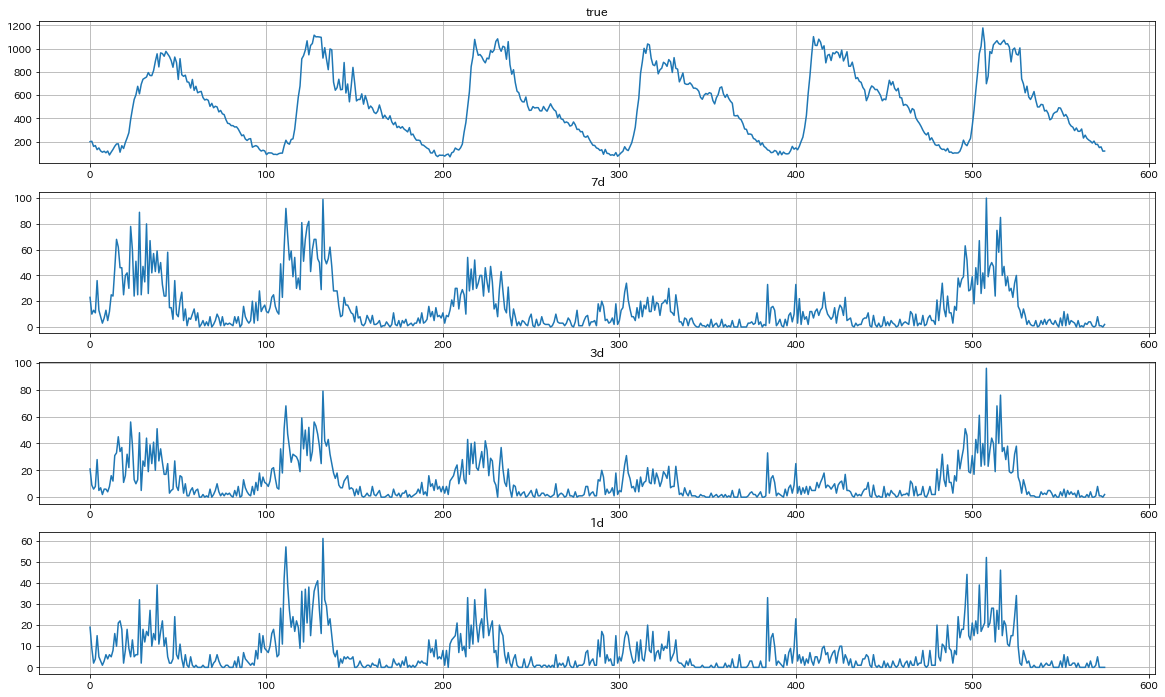

In [207]:
fig, axes = plt.subplots(4, 1, figsize=(20, 12))

xs = range(len(sub))
ticks = range(0, len(xs), 4)
labels = list(range(24)) * (len(ticks) // 24)

axes[0].plot(xs, sub['allCars'])
# axes[0].set_xticks(ticks=ticks, labels=labels)
axes[0].set_title('true')
axes[0].grid()

axes[1].plot(xs, sub['search_15min'])
# axes[0].set_xticks(ticks=ticks, labels=labels)
axes[1].set_title('7d')
axes[1].grid()

axes[2].plot(xs, sub_s3['search'])
# axes[1].set_xticks(ticks=ticks, labels=labels)
axes[2].set_title('3d')
axes[2].grid()

axes[3].plot(xs, sub_s1['search'])
# axes[2].set_xticks(ticks=ticks, labels=labels)
axes[3].set_title('1d')
axes[3].grid()

plt.show()

#### 2021/7

In [208]:
df_s1 = pd.read_csv(f'{DATA_DIR}/counts/202107_1d_15min.csv', dtype=dtypes, parse_dates=True, index_col='passing_time').reset_index()
df_s3 = pd.read_csv(f'{DATA_DIR}/counts/202107_3d_15min.csv', dtype=dtypes, parse_dates=True, index_col='passing_time').reset_index()

In [209]:
df_s1 = df_s1.set_index('passing_time').groupby(['start_code', 'end_code'])\
            .apply(lambda g: g.reindex(pd.date_range(start=df_s1.passing_time.min(), end=df_s1.passing_time.max(), freq='15min')).fillna(0))\
            .search\
            .reset_index()

df_s3 = df_s3.set_index('passing_time').groupby(['start_code', 'end_code'])\
            .apply(lambda g: g.reindex(pd.date_range(start=df_s3.passing_time.min(), end=df_s3.passing_time.max(), freq='15min')).fillna(0))\
            .search\
            .reset_index()

In [210]:
start = "川越"
end = "三芳ＰＡ"

In [211]:
sub = df.query(f'start_name == "{start}"  & end_name == "{end}"')
sub = sub.loc[sub['datetime'] >= pd.Timestamp('2021/7/1')]\
          .loc[sub['datetime'] < pd.Timestamp('2021/7/6')]

sub_s1 = df_s1.query(f'start_code == "{name2code[start]}"  & end_code == "{name2code[end]}"')
sub_s3 = df_s3.query(f'start_code == "{name2code[start]}"  & end_code == "{name2code[end]}"')

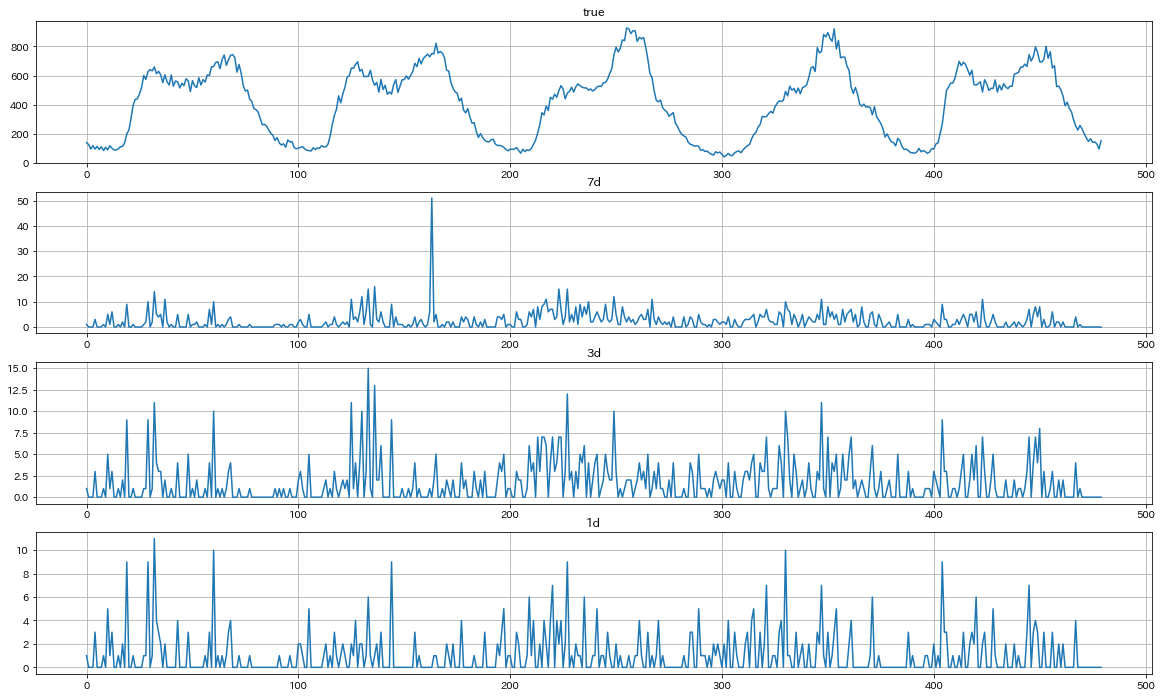

In [212]:
fig, axes = plt.subplots(4, 1, figsize=(20, 12))

xs = range(len(sub))
ticks = range(0, len(xs), 4)
labels = list(range(24)) * (len(ticks) // 24)

axes[0].plot(xs, sub['allCars'])
# axes[0].set_xticks(ticks=ticks, labels=labels)
axes[0].set_title('true')
axes[0].grid()

axes[1].plot(xs, sub['search_15min'])
# axes[0].set_xticks(ticks=ticks, labels=labels)
axes[1].set_title('7d')
axes[1].grid()

axes[2].plot(xs, sub_s3['search'])
# axes[1].set_xticks(ticks=ticks, labels=labels)
axes[2].set_title('3d')
axes[2].grid()

axes[3].plot(xs, sub_s1['search'])
# axes[2].set_xticks(ticks=ticks, labels=labels)
axes[3].set_title('1d')
axes[3].grid()

plt.show()

In [213]:
sub = df.query(f'start_name == "{end}"  & end_name == "{start}"')
sub = sub.loc[sub['datetime'] >= pd.Timestamp('2021/7/1')]\
          .loc[sub['datetime'] < pd.Timestamp('2021/7/6')]

sub_s1 = df_s1.query(f'start_code == "{name2code[end]}"  & end_code == "{name2code[start]}"')
sub_s3 = df_s3.query(f'start_code == "{name2code[end]}"  & end_code == "{name2code[start]}"')

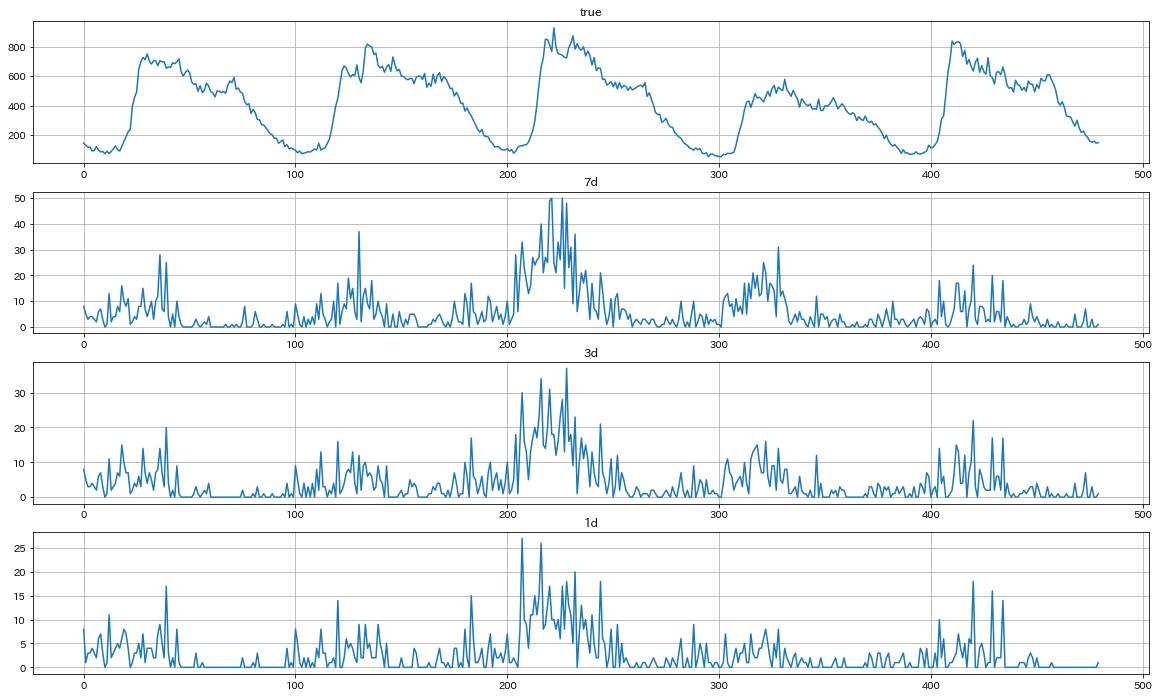

In [214]:
fig, axes = plt.subplots(4, 1, figsize=(20, 12))

xs = range(len(sub))
ticks = range(0, len(xs), 4)
labels = list(range(24)) * (len(ticks) // 24)

axes[0].plot(xs, sub['allCars'])
# axes[0].set_xticks(ticks=ticks, labels=labels)
axes[0].set_title('true')
axes[0].grid()

axes[1].plot(xs, sub['search_15min'])
# axes[0].set_xticks(ticks=ticks, labels=labels)
axes[1].set_title('7d')
axes[1].grid()

axes[2].plot(xs, sub_s3['search'])
# axes[1].set_xticks(ticks=ticks, labels=labels)
axes[2].set_title('3d')
axes[2].grid()

axes[3].plot(xs, sub_s1['search'])
# axes[2].set_xticks(ticks=ticks, labels=labels)
axes[3].set_title('1d')
axes[3].grid()

plt.show()

### 検索と台数の関係を可視化

#### 2022/5/3 （渋滞するとき） vs 2022/5/14 （普通の休日） vs 2022/5/11 (普通の平日)

In [15]:
start = "川越"
end = "三芳ＰＡ"

In [16]:
sub = df_h.query(f'start_name == "{start}"  & end_name == "{end}"')

sub1 = sub.loc[sub['datetime'] >= pd.Timestamp('2022/5/3')]\
          .loc[sub['datetime'] < pd.Timestamp('2022/5/4')]

sub2 = sub.loc[sub['datetime'] >= pd.Timestamp('2022/5/14')]\
          .loc[sub['datetime'] < pd.Timestamp('2022/5/15')]

sub3 = sub.loc[sub['datetime'] >= pd.Timestamp('2022/5/11')]\
          .loc[sub['datetime'] < pd.Timestamp('2022/5/12')]

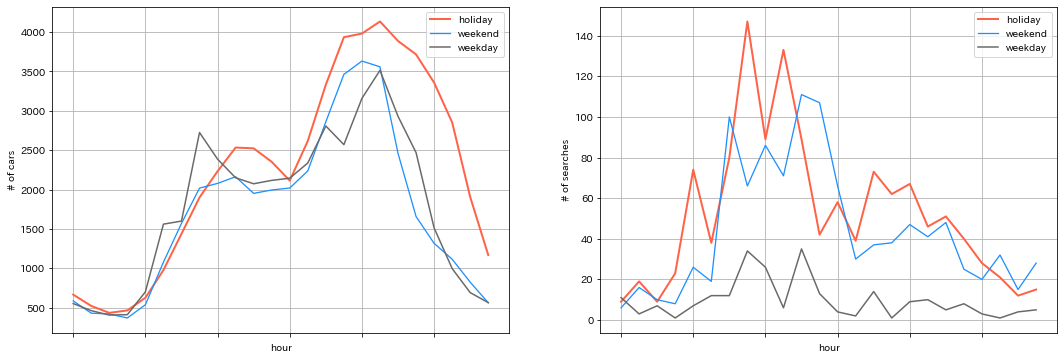

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

xs = range(len(sub1))
ticks = range(0, len(xs), 4)
labels = list(range(24)) * (len(ticks) // 24)

axes[0].plot(xs, sub1['allCars'], label='holiday', color='tomato', lw=2)
axes[0].plot(xs, sub2['allCars'], label='weekend', color='dodgerblue', lw=1.3)
axes[0].plot(xs, sub3['allCars'], label='weekday', color='dimgray')
axes[0].set_xticks(ticks=ticks, labels=labels)
axes[0].set_xlabel('hour')
axes[0].set_ylabel('# of cars')
axes[0].grid()
axes[0].legend()


axes[1].plot(xs, sub1['search_1h'], label='holiday', color='tomato', lw=2)
axes[1].plot(xs, sub2['search_1h'], label='weekend', color='dodgerblue', lw=1.3)
axes[1].plot(xs, sub3['search_1h'], label='weekday', color='dimgray')
axes[1].set_xticks(ticks=ticks, labels=labels)
axes[1].set_xlabel('hour')
axes[1].set_ylabel('# of searches')
axes[1].grid()
axes[1].legend()

plt.show()

In [18]:
sub = df.query(f'start_name == "{end}"  & end_name == "{start}"')

sub1 = sub.loc[sub['datetime'] >= pd.Timestamp('2022/5/3')]\
          .loc[sub['datetime'] < pd.Timestamp('2022/5/4')]

sub2 = sub.loc[sub['datetime'] >= pd.Timestamp('2022/5/14')]\
          .loc[sub['datetime'] < pd.Timestamp('2022/5/15')]

sub3 = sub.loc[sub['datetime'] >= pd.Timestamp('2022/5/11')]\
          .loc[sub['datetime'] < pd.Timestamp('2022/5/12')]

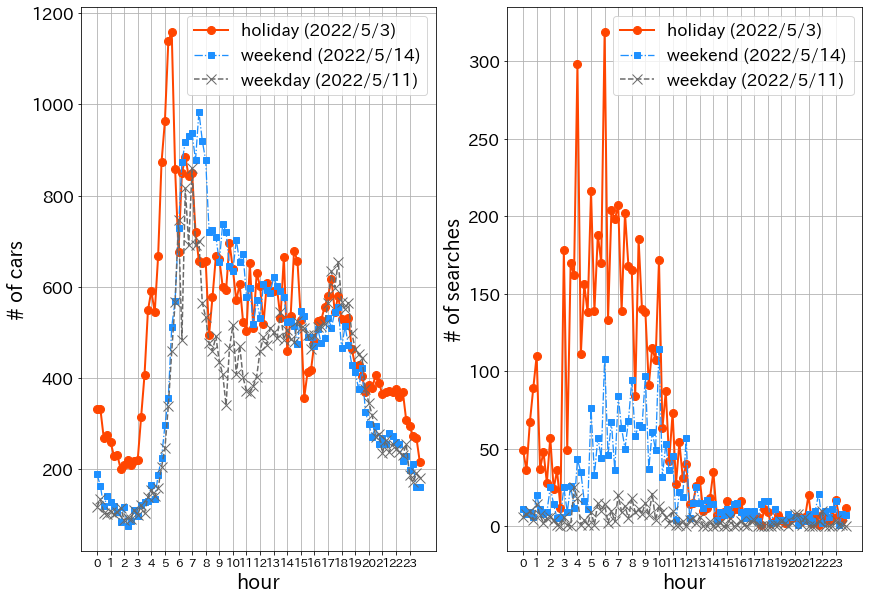

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(14, 10))

xs = range(len(sub1))
ticks = range(0, len(xs), 4)
labels = [str(h) for h in list(range(24)) * (len(ticks) // 24)]

axes[0].plot(xs, sub1['allCars'], '-o', label='holiday (2022/5/3)', color='orangered', lw=2, markersize=8)
axes[0].plot(xs, sub2['allCars'], '-.s', label='weekend (2022/5/14)', color='dodgerblue', lw=1.3, markersize=6)
axes[0].plot(xs, sub3['allCars'], '--x', label='weekday (2022/5/11)', color='dimgrey', markersize=10)
axes[0].set_xticks(ticks=ticks, labels=labels)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=17)
axes[0].set_xlabel('hour', fontsize=20)
axes[0].set_ylabel('# of cars', fontsize=20)
axes[0].grid()
axes[0].legend(fontsize=17)


axes[1].plot(xs, sub1['search_15min'], '-o', label='holiday (2022/5/3)', color='orangered', lw=2, markersize=8)
axes[1].plot(xs, sub2['search_15min'], '-.s', label='weekend (2022/5/14)', color='dodgerblue', lw=1.3, markersize=6)
axes[1].plot(xs, sub3['search_15min'], '--x', label='weekday (2022/5/11)', color='dimgrey', markersize=10)
axes[1].set_xticks(ticks=ticks, labels=labels)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=17)
axes[1].set_xlabel('hour', fontsize=20)
axes[1].set_ylabel('# of searches', fontsize=20)
axes[1].grid()
axes[1].legend(fontsize=17)

# plt.savefig('../../figs/cars_searches2.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

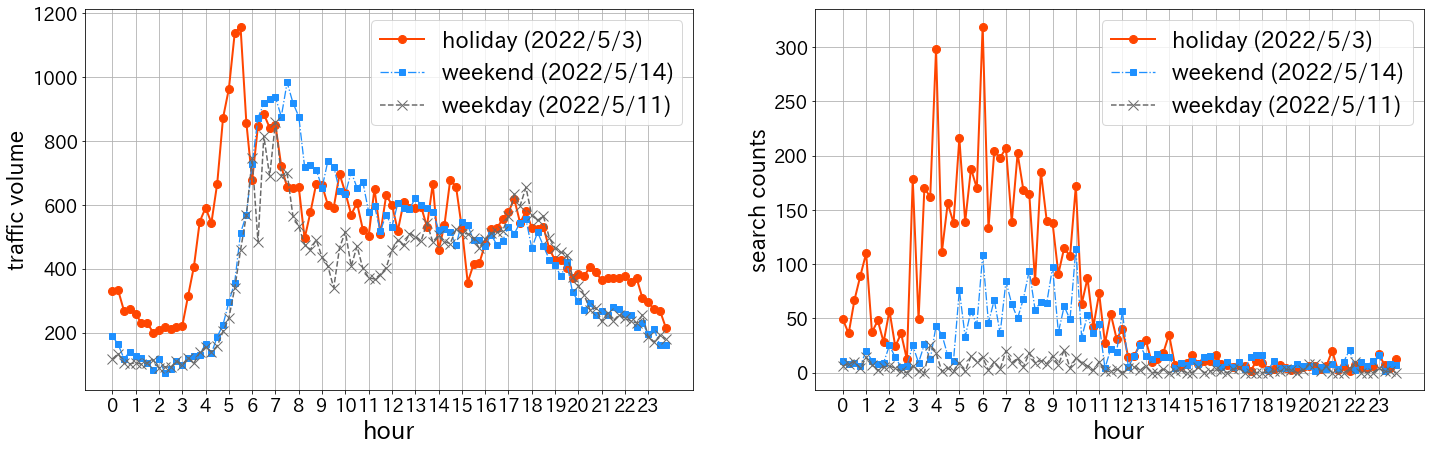

In [81]:
fig, axes = plt.subplots(1, 2, figsize=(24, 7))

xs = range(len(sub1))
ticks = range(0, len(xs), 4)
labels = [str(h) for h in list(range(24)) * (len(ticks) // 24)]

axes[0].plot(xs, sub1['allCars'], '-o', label='holiday (2022/5/3)', color='orangered', lw=2, markersize=8)
axes[0].plot(xs, sub2['allCars'], '-.s', label='weekend (2022/5/14)', color='dodgerblue', lw=1.3, markersize=6)
axes[0].plot(xs, sub3['allCars'], '--x', label='weekday (2022/5/11)', color='dimgrey', markersize=10)
axes[0].set_xticks(ticks=ticks, labels=labels)
axes[0].tick_params(axis='x', labelsize=18)
axes[0].tick_params(axis='y', labelsize=18)
axes[0].set_xlabel('hour', fontsize=24)
axes[0].set_ylabel('traffic volume', fontsize=22)
axes[0].grid()
axes[0].legend(fontsize=22)


axes[1].plot(xs, sub1['search_15min'], '-o', label='holiday (2022/5/3)', color='orangered', lw=2, markersize=8)
axes[1].plot(xs, sub2['search_15min'], '-.s', label='weekend (2022/5/14)', color='dodgerblue', lw=1.3, markersize=6)
axes[1].plot(xs, sub3['search_15min'], '--x', label='weekday (2022/5/11)', color='dimgrey', markersize=10)
axes[1].set_xticks(ticks=ticks, labels=labels)
axes[1].tick_params(axis='x', labelsize=18)
axes[1].tick_params(axis='y', labelsize=18)
axes[1].set_xlabel('hour', fontsize=24)
axes[1].set_ylabel('search counts', fontsize=22)
axes[1].grid()
axes[1].legend(fontsize=22)

# plt.savefig('../../figs/cars_searches3.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

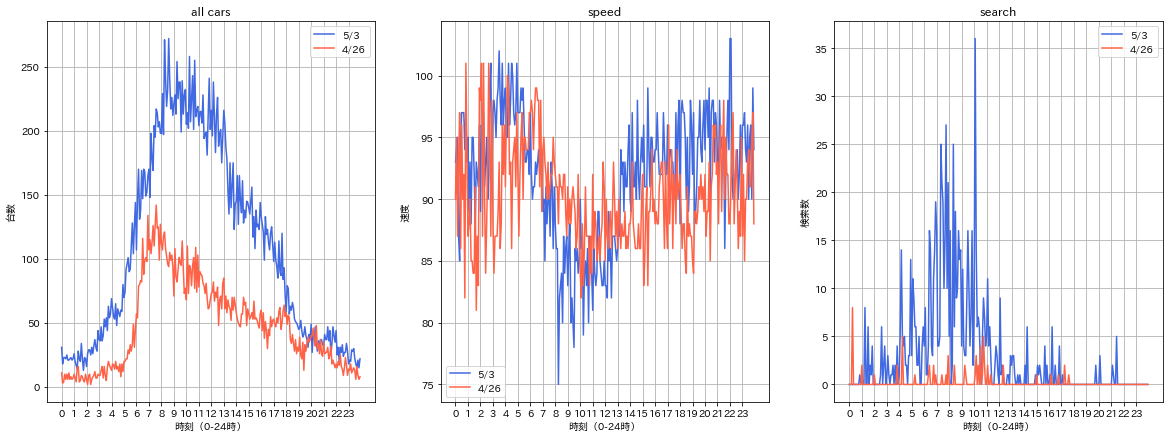

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(20,7))
ticks = range(0, 288, 12)
labels = range(24)

ax = axes[0]
ax.plot(range(288), tat_sub1['allCars'], color='royalblue', label='5/3')
ax.plot(range(288), tat_sub2['allCars'], color='tomato', label='4/26')
ax.set_xlabel('時刻（0-24時）')
ax.set_ylabel('台数')
ax.set_title('all cars')
ax.set_xticks(ticks=ticks, labels=labels)
ax.grid()
ax.legend()

ax = axes[1]
ax.plot(range(288), tat_sub1['speed'], color='royalblue', label='5/3')
ax.plot(range(288), tat_sub2['speed'], color='tomato', label='4/26')

ax.set_xlabel('時刻（0-24時）')
ax.set_ylabel('速度')
ax.set_title('speed')
ax.set_xticks(ticks=ticks, labels=labels)
ax.grid()
ax.legend()

ax = axes[2]
ax.plot(range(288), tat_sub1['search_5min'], color='royalblue', label='5/3')
ax.plot(range(288), tat_sub2['search_5min'], color='tomato', label='4/26')

ax.set_xlabel('時刻（0-24時）')
ax.set_ylabel('検索数')
ax.set_title('search')
ax.set_xticks(ticks=ticks, labels=labels)
ax.grid()
ax.legend()

plt.show()

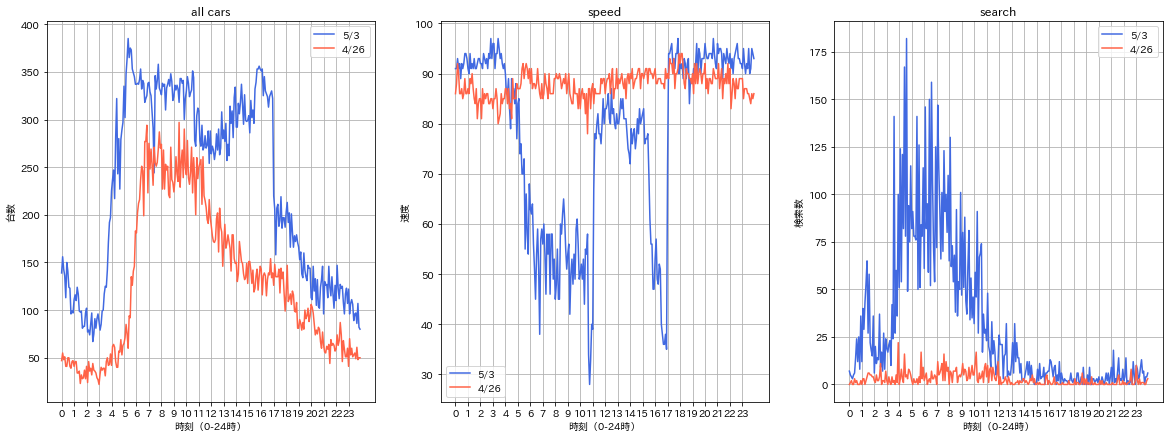

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(20,7))
ticks = range(0, 288, 12)
labels = range(24)

ax = axes[0]
ax.plot(range(288), kan_sub1['allCars'], color='royalblue', label='5/3')
ax.plot(range(288), kan_sub2['allCars'], color='tomato', label='4/26')
ax.set_xlabel('時刻（0-24時）')
ax.set_ylabel('台数')
ax.set_title('all cars')
ax.set_xticks(ticks=ticks, labels=labels)
ax.grid()
ax.legend()

ax = axes[1]
ax.plot(range(288), kan_sub1['speed'], color='royalblue', label='5/3')
ax.plot(range(288), kan_sub2['speed'], color='tomato', label='4/26')

ax.set_xlabel('時刻（0-24時）')
ax.set_ylabel('速度')
ax.set_title('speed')
ax.set_xticks(ticks=ticks, labels=labels)
ax.grid()
ax.legend()

ax = axes[2]
ax.plot(range(288), kan_sub1['search_5min'], color='royalblue', label='5/3')
ax.plot(range(288), kan_sub2['search_5min'], color='tomato', label='4/26')

ax.set_xlabel('時刻（0-24時）')
ax.set_ylabel('検索数')
ax.set_title('search')
ax.set_xticks(ticks=ticks, labels=labels)
ax.grid()
ax.legend()

plt.show()

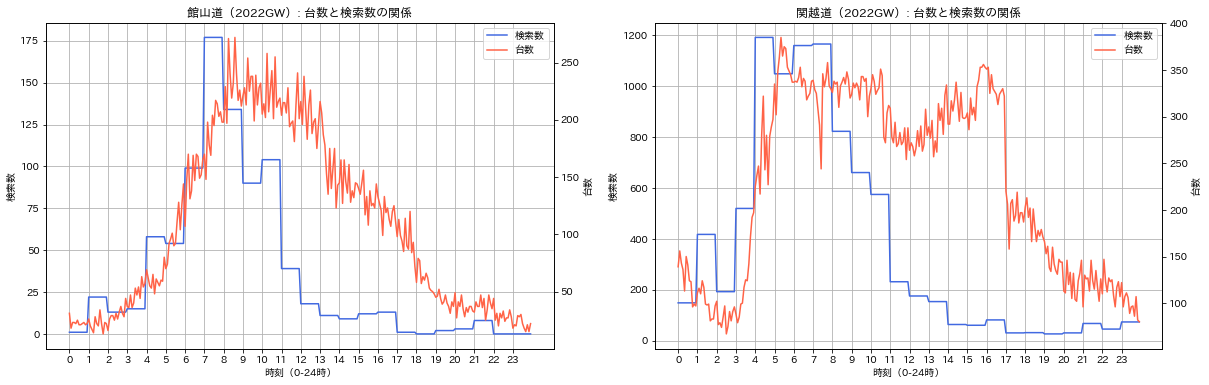

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
ticks = range(0, 288, 12)
labels = range(24)

ax = axes[0]
ax2 = ax.twinx()
ax.plot(range(288), tat_sub1['search_1h'], color='royalblue', label='検索数')
ax2.plot(range(288), tat_sub1['allCars'], color='tomato', label='台数')
ax.set_xlabel('時刻（0-24時）')
ax.set_ylabel('検索数')
ax2.set_ylabel('台数')
ax.set_title('館山道（2022GW）: 台数と検索数の関係')
ax.set_xticks(ticks=ticks, labels=labels)
ax.grid()

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)

ax = axes[1]
ax2 = ax.twinx()
ax.plot(range(288), kan_sub1['search_1h'], color='royalblue', label='検索数')
ax2.plot(range(288), kan_sub1['allCars'], color='tomato', label='台数')

ax.set_xlabel('時刻（0-24時）')
ax.set_ylabel('検索数')
ax2.set_ylabel('台数')
ax.set_title('関越道（2022GW）: 台数と検索数の関係')
ax.set_xticks(ticks=ticks, labels=labels)
ax.grid()

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)

plt.show()

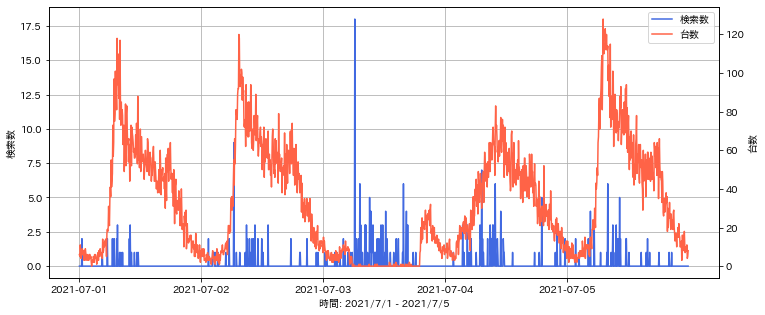

In [66]:
tmp = tat[(tat['datetime'] >= pd.Timestamp('2021/7/1')) & (tat['datetime'] < pd.Timestamp('2021/7/6'))]
tmp = tmp[(tmp['start_name'] == '木更津ＪＣＴ') & (tmp['end_name'] == '木更津南ＪＣＴ')]

xs = range(12 * 24 * 5)
ticks = range(0, len(xs), 12*24)
labels = tmp['datetime'].dt.date.unique()

fig, ax = plt.subplots(figsize=(12, 5))
ax2 = ax.twinx()
ax.plot(xs, tmp['search_5min'], color='royalblue', label='検索数')
ax2.plot(xs, tmp['allCars'], color='tomato', label='台数')
ax.set_xlabel('時間: 2021/7/1 - 2021/7/5')
ax.set_ylabel('検索数')
ax2.set_ylabel('台数')
ax.set_xticks(ticks=ticks, labels=labels)
ax.grid()

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)

plt.show()

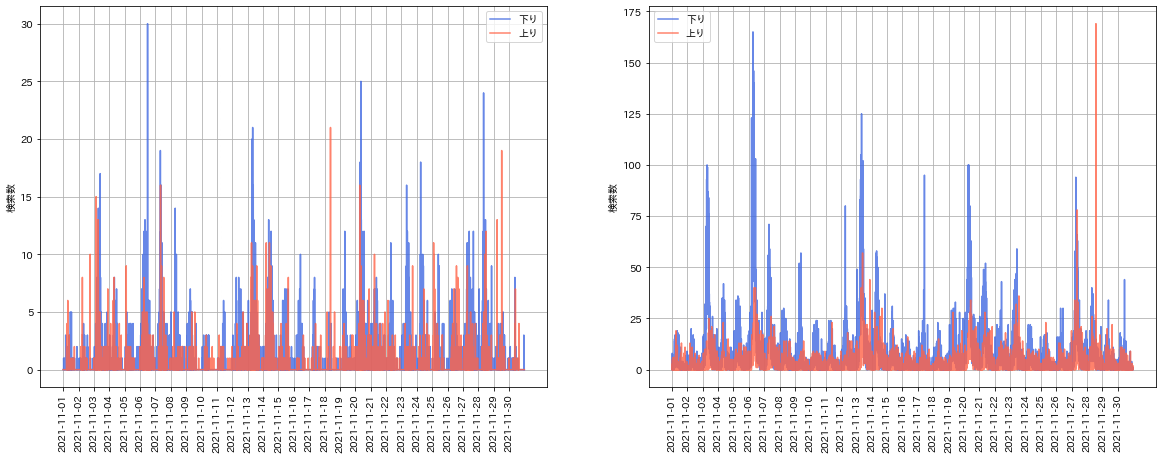

In [113]:
tat_sub = tat[tat['datetime'].dt.month == 11]
kan_sub = kan[kan['datetime'].dt.month == 11]
tat_sub1 = tat_sub[(tat_sub['start_name'] == '木更津ＪＣＴ') & (tat_sub['end_name'] == '木更津南ＪＣＴ')]
tat_sub2 = tat_sub[(tat_sub['end_name'] == '木更津ＪＣＴ') & (tat_sub['start_name'] == '木更津南ＪＣＴ')]
kan_sub1 = kan_sub[(kan_sub['start_name'] == '東松山') & (kan_sub['end_name'] == '嵐山小川')]
kan_sub2 = kan_sub[(kan_sub['end_name'] == '東松山') & (kan_sub['start_name'] == '嵐山小川')]


fig, axes = plt.subplots(1, 2, figsize=(20, 7))
xs = range(12 * 24 * 30)
ticks = range(0, 12 * 24 * 30, 12 * 24)
labels = tat_sub['datetime'].dt.date.unique()

ax = axes[0]
ax.plot(xs, tat_sub1['search_5min'], color='royalblue', label='下り', alpha=0.8)
ax.plot(xs, tat_sub2['search_5min'], color='tomato', label='上り', alpha=0.8)
ax.set_ylabel('検索数')
ax.set_xticks(ticks=ticks, labels=labels, rotation=90)
ax.grid()

ax.legend()

ax = axes[1]
ax.plot(xs, kan_sub1['search_5min'], color='royalblue', label='下り', alpha=0.8)
ax.plot(xs, kan_sub2['search_5min'], color='tomato', label='上り', alpha=0.8)
ax.set_ylabel('検索数')
ax.set_xticks(ticks=ticks, labels=labels, rotation=90)
ax.grid()

ax.legend()

plt.show()

## 時間指定なしデータ

### 可視化

In [6]:
def resample_search(df, sr):
  agg_map = {
      'search': 'sum'
  }

  return df.set_index('search_date').groupby(['start_code', 'end_code']).apply(lambda g: g.resample(sr).agg(agg_map)).reset_index()

def resample_traffic(df, sr):
  agg_map = {
    'total': 'sum',
    'speed': 'mean',
    'KP': 'mean'
  }

  return df.set_index('datetime').groupby(['start_name', 'end_name']).apply(lambda g: g.resample(sr).agg(agg_map)).reset_index()

In [91]:
df_tateyama = pd.read_csv(UNSPECIFIED_SEARCH_COUNT_TATEYAMA_CSV, index_col='search_date', parse_dates=True,
                          dtype={'start_code': str, 'end_code': str}).reset_index()
df_kannetsu = pd.read_csv(UNSPECIFIED_SEARCH_COUNT_KANNETSU_CSV, index_col='search_date', parse_dates=True,
                          dtype={'start_code': str, 'end_code': str}).reset_index()

# df_tateyama['search'] = df_tateyama.groupby(['start_code','end_code'])['search'].shift(1)
# df_kannetsu['search'] = df_kannetsu.groupby(['start_code','end_code'])['search'].shift(1)

In [67]:
df_tateyama.describe()

search
count  8057.000000
mean    361.169666
std     239.094603
min       1.000000
25%     166.000000
50%     364.000000
75%     512.000000
max    3643.000000

In [68]:
df_kannetsu.describe()

search
count  38688.000000
mean    2210.219655
std     1741.351511
min      184.000000
25%      909.000000
50%     1613.000000
75%     2938.000000
max    12794.000000

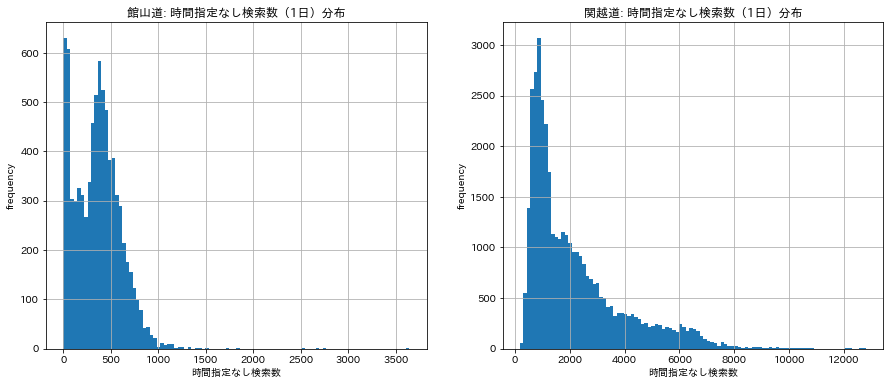

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].hist(df_tateyama['search'], bins=100)
axes[0].set_xlabel('時間指定なし検索数')
axes[0].set_ylabel('frequency')
axes[0].set_title('館山道: 時間指定なし検索数（1日）分布')
axes[0].grid()

axes[1].hist(df_kannetsu['search'], bins=100)
axes[1].set_xlabel('時間指定なし検索数')
axes[1].set_ylabel('frequency')
axes[1].set_title('関越道: 時間指定なし検索数（1日）分布')
axes[1].grid()

plt.show()

In [72]:
df_tateyama.sort_values('search', ascending=False)

search_date start_code end_code  search start_name end_name
4828  2021-11-28    1130031  1130026    3643    木更津南ＪＣＴ   木更津ＪＣＴ
4830  2021-11-28    1130036  1130031    2761         君津  木更津南ＪＣＴ
4832  2021-11-28    1130039  1130036    2670       君津ＰＡ       君津
4834  2021-11-28    1130041  1130039    2525       富津中央     君津ＰＡ
7927  2022-05-02    1130026  1130031    1847     木更津ＪＣＴ  木更津南ＪＣＴ
...          ...        ...      ...     ...        ...      ...
1337  2021-06-06    1130046  1130041       1       富津竹岡     富津中央
2676  2021-08-12    1130046  1130041       1       富津竹岡     富津中央
1916  2021-07-05    1130046  1130041       1       富津竹岡     富津中央
3956  2021-10-15    1130046  1130041       1       富津竹岡     富津中央
977   2021-05-19    1130046  1130041       1       富津竹岡     富津中央

[8057 rows x 6 columns]

In [73]:
df_kannetsu.sort_values('search', ascending=False)

search_date start_code end_code  search start_name end_name
38029  2022-05-02    1800021  1800026   12794     鶴ヶ島ＪＣＴ      鶴ヶ島
38031  2022-05-02    1800026  1800028   12774        鶴ヶ島  坂戸西スマート
38037  2022-05-02    1800036  1800041   12750        東松山     嵐山小川
38033  2022-05-02    1800028  1800031   12711    坂戸西スマート     高坂ＳＡ
38035  2022-05-02    1800031  1800036   12711       高坂ＳＡ      東松山
...           ...        ...      ...     ...        ...      ...
4513   2021-05-18    1110210  1800001     216      大泉ＪＣＴ       練馬
3457   2021-05-07    1110210  1800001     206      大泉ＪＣＴ       練馬
5377   2021-05-27    1110210  1800001     204      大泉ＪＣＴ       練馬
3937   2021-05-12    1110210  1800001     197      大泉ＪＣＴ       練馬
4705   2021-05-20    1110210  1800001     184      大泉ＪＣＴ       練馬

[38688 rows x 6 columns]

In [74]:
df_tateyama.groupby(['start_name', 'end_name']).mean().reset_index().sort_values('search', ascending=False)

start_name        end_name      search
19          木更津ＪＣＴ         木更津南ＪＣＴ  758.300248
0   京葉道路・館山自動車道接続部              市原  675.803970
11              市原            市原ＳＡ  561.565757
12            市原ＳＡ           姉崎袖ヶ浦  561.565757
16         木更津南ＪＣＴ              君津  558.347395
6            姉崎袖ヶ浦            木更津北  498.022333
15            木更津北          木更津ＪＣＴ  491.791563
18          木更津ＪＣＴ            木更津北  418.101737
10              市原  京葉道路・館山自動車道接続部  412.965261
14            木更津北           姉崎袖ヶ浦  356.359801
13            市原ＳＡ              市原  356.173697
5            姉崎袖ヶ浦            市原ＳＡ  356.173697
17         木更津南ＪＣＴ          木更津ＪＣＴ  347.364764
1               君津            君津ＰＡ  228.843672
2               君津         木更津南ＪＣＴ  198.918114
4             君津ＰＡ            富津中央  177.411911
3             君津ＰＡ              君津   94.880893
7             富津中央            君津ＰＡ   80.337469
8             富津中央            富津竹岡   58.828784
9             富津竹岡            富津中央   29.165000

In [75]:
df_kannetsu.groupby(['start_name', 'end_name']).mean().reset_index().sort_values('search', ascending=False)

start_name end_name       search
95     鶴ヶ島ＪＣＴ      鶴ヶ島  6032.389578
92        鶴ヶ島  坂戸西スマート  5988.573201
12    坂戸西スマート     高坂ＳＡ  5932.483871
85       高坂ＳＡ      東松山  5932.483871
50        東松山     嵐山小川  5872.466501
..        ...      ...          ...
17      堀之内ＰＡ       小出   766.325062
14        堀之内    堀之内ＰＡ   766.325062
6         六日町     塩沢石打   759.181141
22       大和ＰＡ      六日町   758.071960
25      大泉ＪＣＴ       練馬   446.957816

[96 rows x 3 columns]

In [76]:
tmp_tat = df_tateyama.groupby(['search_date']).apply(lambda g: g['search'].agg(sum='sum')).reset_index()
tmp_kan = df_kannetsu.groupby(['search_date']).apply(lambda g: g['search'].agg(sum='sum')).reset_index()

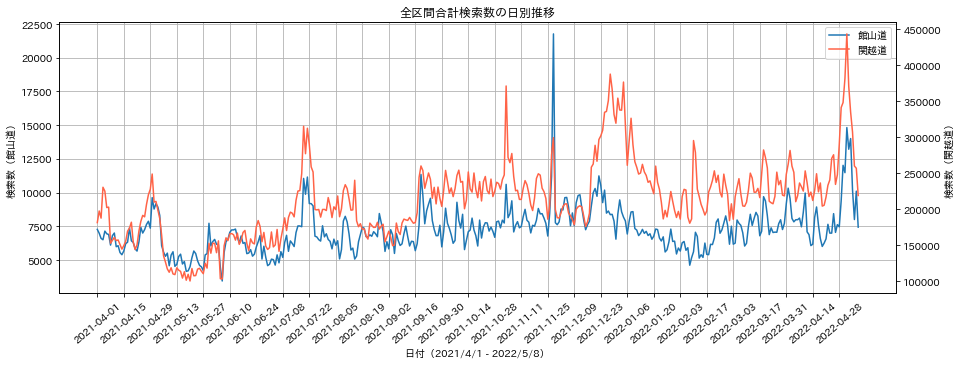

In [77]:
fig, ax = plt.subplots(figsize=(15,5))
ax2 = ax.twinx()

ax.plot(range(len(tmp_tat)), tmp_tat['sum'], label='館山道', lw=1.5)
ax2.plot(range(len(tmp_kan)), tmp_kan['sum'], color='tomato', label='関越道', lw=1.5)

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)

ax.set_xlabel('日付（2021/4/1 - 2022/5/8）')
ax.set_ylabel('検索数（館山道）')
ax2.set_ylabel('検索数（関越道）')
ax.set_title('全区間合計検索数の日別推移')

ticks = range(0, len(tmp_tat), 14)
ax.set_xticks(ticks=ticks, labels=tmp_tat['search_date'].iloc[ticks].dt.date, rotation=40)

ax.grid()

plt.show()

In [93]:
df_tateyama['start_name'] = df_tateyama['start_code'].map(code2name)
df_tateyama['end_name'] = df_tateyama['end_code'].map(code2name)
df_kannetsu['start_name'] = df_kannetsu['start_code'].map(code2name)
df_kannetsu['end_name'] = df_kannetsu['end_code'].map(code2name)

In [78]:
df_tateyama.sort_values('search', ascending=False)[['start_name', 'end_name', 'search', 'search_date']].head(15).reset_index(drop=True)

start_name end_name  search search_date
0          木更津南ＪＣＴ   木更津ＪＣＴ    3643  2021-11-28
1               君津  木更津南ＪＣＴ    2761  2021-11-28
2             君津ＰＡ       君津    2670  2021-11-28
3             富津中央     君津ＰＡ    2525  2021-11-28
4           木更津ＪＣＴ  木更津南ＪＣＴ    1847  2022-05-02
5           木更津ＪＣＴ  木更津南ＪＣＴ    1737  2022-05-03
6           木更津ＪＣＴ  木更津南ＪＣＴ    1509  2022-05-04
7           木更津ＪＣＴ  木更津南ＪＣＴ    1442  2022-05-01
8           木更津ＪＣＴ  木更津南ＪＣＴ    1409  2021-09-19
9           木更津ＪＣＴ  木更津南ＪＣＴ    1348  2022-04-30
10         木更津南ＪＣＴ       君津    1337  2022-05-03
11         木更津南ＪＣＴ       君津    1337  2022-05-02
12  京葉道路・館山自動車道接続部       市原    1257  2022-05-02
13          木更津ＪＣＴ  木更津南ＪＣＴ    1255  2022-04-29
14          木更津ＪＣＴ  木更津南ＪＣＴ    1252  2021-05-02

In [79]:
df_kannetsu.sort_values('search', ascending=False)[['start_name', 'end_name', 'search', 'search_date']].head(15).reset_index(drop=True)

start_name end_name  search search_date
0      鶴ヶ島ＪＣＴ      鶴ヶ島   12794  2022-05-02
1         鶴ヶ島  坂戸西スマート   12774  2022-05-02
2         東松山     嵐山小川   12750  2022-05-02
3     坂戸西スマート     高坂ＳＡ   12711  2022-05-02
4        高坂ＳＡ      東松山   12711  2022-05-02
5        嵐山小川     嵐山ＰＡ   12614  2022-05-02
6        嵐山ＰＡ       花園   12614  2022-05-02
7        上里ＳＡ    藤岡ＪＣＴ   12183  2022-05-02
8        本庄児玉     上里ＳＡ   12165  2022-05-02
9          花園     寄居ＰＡ   12124  2022-05-02
10       寄居ＰＡ     本庄児玉   12122  2022-05-02
11     鶴ヶ島ＪＣＴ      鶴ヶ島   10935  2021-11-03
12        東松山     嵐山小川   10881  2021-11-03
13        鶴ヶ島  坂戸西スマート   10862  2021-11-03
14       嵐山ＰＡ       花園   10809  2021-11-03

### ヒートマップ

#### 2022/4/29 - 2022/5/8

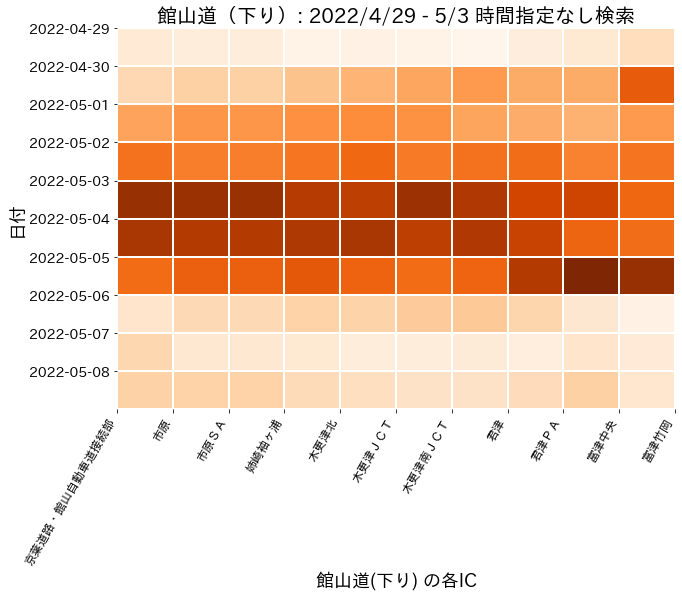

In [22]:
tat_down, tat_up, ts = get_congmat(df_tateyama, '1d', '20220429', '20220508', road_code='1130', df_type='search_unspecified')

values = zscore(tat_down, axis=0)

xlabel = '館山道(下り) の各IC'
ylabel = '日付'
title = '館山道（下り）: 2022/4/29 - 5/3 時間指定なし検索'

xticklabels = [code2name[c] for c in order_tateyama['down'].keys()]
yticklabels = ts

fig, ax = plt.subplots(1,1, figsize=(10,7))

plot_heatmap(values, xlabel, ylabel, title, xticklabels, yticklabels, ax)

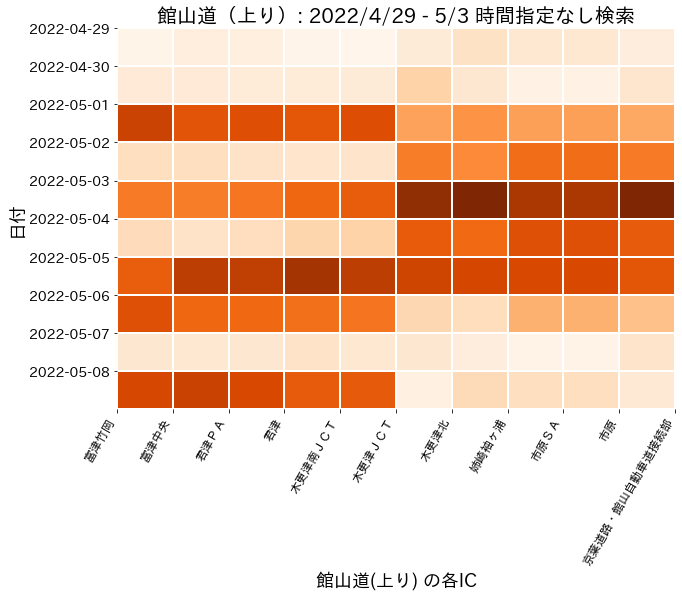

In [23]:
values = zscore(tat_up, axis=0)

xlabel = '館山道(上り) の各IC'
ylabel = '日付'
title = '館山道（上り）: 2022/4/29 - 5/3 時間指定なし検索'

xticklabels = [code2name[c] for c in order_tateyama['up'].keys()]
yticklabels = ts

fig, ax = plt.subplots(1,1, figsize=(10,7))

plot_heatmap(values, xlabel, ylabel, title, xticklabels, yticklabels, ax)

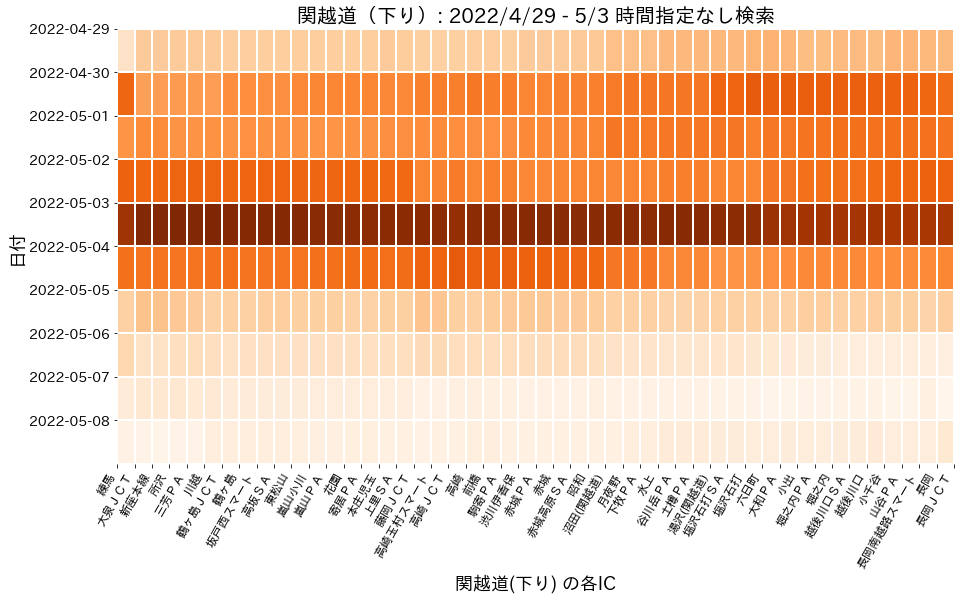

In [24]:
kan_down, kan_up, ts = get_congmat(df_kannetsu, '1d', '20220429', '20220508', road_code='1800', df_type='search_unspecified')

values = zscore(kan_down, axis=0)

xlabel = '関越道(下り) の各IC'
ylabel = '日付'
title = '関越道（下り）: 2022/4/29 - 5/3 時間指定なし検索'

xticklabels = [code2name[c] for c in order_kannetsu['down'].keys()]
yticklabels = ts

fig, ax = plt.subplots(1,1, figsize=(15,8))

plot_heatmap(values, xlabel, ylabel, title, xticklabels, yticklabels, ax)

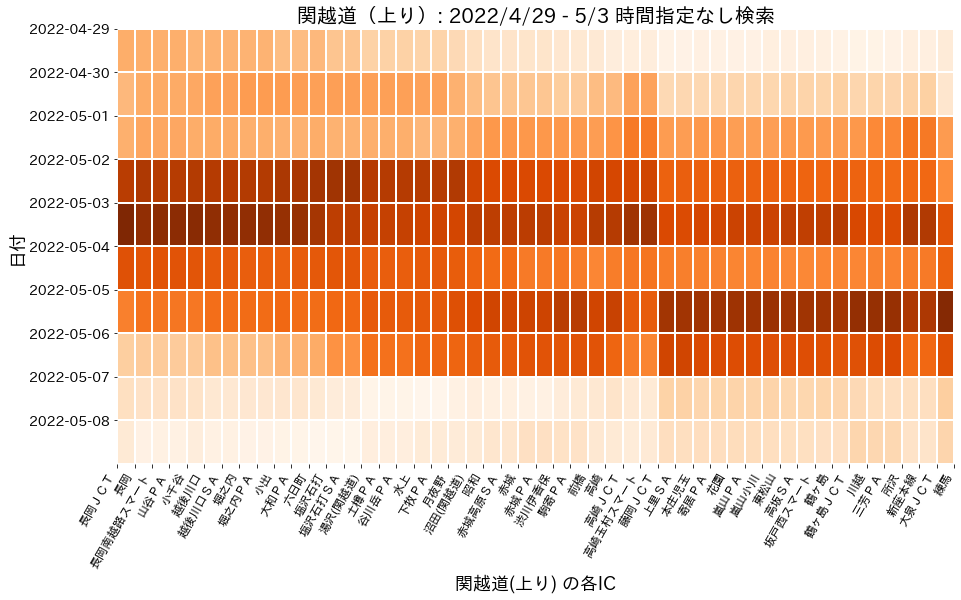

In [25]:
values = zscore(kan_up, axis=0)

xlabel = '関越道(上り) の各IC'
ylabel = '日付'
title = '関越道（上り）: 2022/4/29 - 5/3 時間指定なし検索'

xticklabels = [code2name[c] for c in order_kannetsu['up'].keys()]
yticklabels = ts

fig, ax = plt.subplots(1,1, figsize=(15,8))

plot_heatmap(values, xlabel, ylabel, title, xticklabels, yticklabels, ax)

### 「台数」との比較

In [26]:
def merge_traffic_search(traffic, search):
  df = pd.merge(traffic, search, how='left',
                left_on=['datetime', 'start_name', 'end_name'], 
                right_on=['search_date', 'start_name', 'end_name'])
  df.drop('search_date', axis=1, inplace=True)
  df['search'].fillna(0, inplace=True)

  df['start_code'] = df['start_name'].map(name2code)
  df['end_code'] = df['end_name'].map(name2code)

  cols = ['datetime', 'start_code', 'end_code', 'start_name', 'end_name', 'KP', 'total', 'speed', 'search']
  return df.loc[:,cols]

In [27]:
df_tateyama_traffic = pd.read_csv(TRAFFIC_TATEYAMA_CSV, index_col='datetime', parse_dates=True, 
                                  dtype={'start_code': str, 'end_code': str}).reset_index()

df_kannetsu_traffic = pd.read_csv(TRAFFIC_KANNETSU_CSV, index_col='datetime', parse_dates=True, 
                                  dtype={'start_code': str, 'end_code': str}).reset_index()

In [28]:
tat_tra1d = resample_traffic(df_tateyama_traffic, '1d')
kan_tra1d = resample_traffic(df_kannetsu_traffic, '1d')

In [29]:
tat_tra1d.sort_values('total', ascending=False)[['start_name', 'end_name', 'total', 'datetime']].head(15).reset_index(drop=True)

start_name        end_name    total   datetime
0           木更津ＪＣＴ         木更津南ＪＣＴ  31213.0 2022-05-03
1   京葉道路・館山自動車道接続部              市原  31122.0 2022-05-03
2               市原           姉崎袖ヶ浦  28915.0 2022-05-03
3           木更津ＪＣＴ         木更津南ＪＣＴ  28247.0 2022-05-04
4   京葉道路・館山自動車道接続部              市原  27985.0 2022-05-04
5   京葉道路・館山自動車道接続部              市原  27835.0 2021-12-24
6   京葉道路・館山自動車道接続部              市原  27402.0 2021-07-21
7   京葉道路・館山自動車道接続部              市原  27342.0 2021-08-10
8   京葉道路・館山自動車道接続部              市原  27109.0 2022-03-20
9   京葉道路・館山自動車道接続部              市原  27084.0 2021-05-03
10  京葉道路・館山自動車道接続部              市原  26875.0 2021-10-08
11              市原  京葉道路・館山自動車道接続部  26833.0 2022-05-04
12  京葉道路・館山自動車道接続部              市原  26829.0 2022-03-25
13  京葉道路・館山自動車道接続部              市原  26717.0 2021-11-20
14  京葉道路・館山自動車道接続部              市原  26638.0 2021-07-22

In [30]:
kan_tra1d.sort_values('total', ascending=False)[['start_name', 'end_name', 'total', 'datetime']].head(15).reset_index(drop=True)

start_name end_name    total   datetime
0         鶴ヶ島   鶴ヶ島ＪＣＴ  70228.0 2022-05-05
1      鶴ヶ島ＪＣＴ      鶴ヶ島  69333.0 2022-05-02
2     坂戸西スマート      鶴ヶ島  67697.0 2022-05-05
3        嵐山小川       花園  66620.0 2022-05-03
4         鶴ヶ島  坂戸西スマート  66494.0 2022-05-02
5         鶴ヶ島   鶴ヶ島ＪＣＴ  66373.0 2022-05-04
6      鶴ヶ島ＪＣＴ      鶴ヶ島  66272.0 2022-03-19
7         東松山     嵐山小川  65957.0 2022-05-03
8      鶴ヶ島ＪＣＴ      鶴ヶ島  65272.0 2022-04-28
9         東松山  坂戸西スマート  65214.0 2022-05-05
10        鶴ヶ島   鶴ヶ島ＪＣＴ  64942.0 2022-03-21
11    坂戸西スマート      東松山  64359.0 2022-05-02
12         花園     寄居ＰＡ  63447.0 2022-05-03
13    坂戸西スマート      鶴ヶ島  63442.0 2022-05-04
14       寄居ＰＡ     本庄児玉  63334.0 2022-05-03

#### 台数との相関

In [87]:
# df_tateyama['search'] = df_tateyama.groupby(['start_code','end_code'])['search'].shift(1)
# df_kannetsu['search'] = df_kannetsu.groupby(['start_code','end_code'])['search'].shift(1)

In [94]:
tat = merge_traffic_search(tat_tra1d, df_tateyama)
kan = merge_traffic_search(kan_tra1d, df_kannetsu)

In [95]:
def calc_corr(df, col1, col2):
  return df[[col1, col2]].corr().values[0, 1]

館山道: 0.440
関越道: 0.550


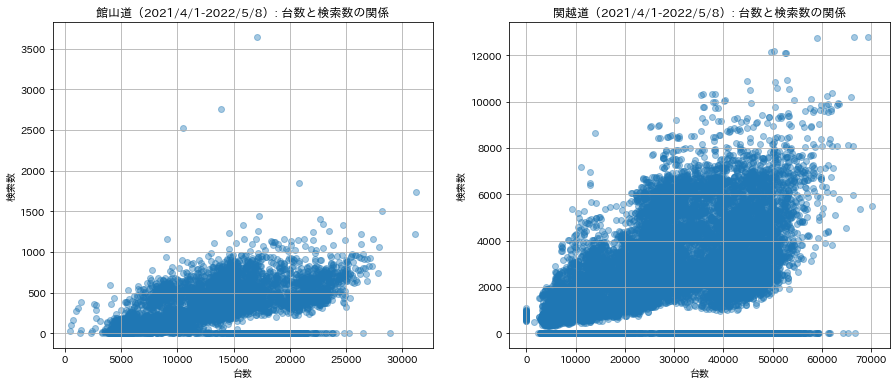

In [96]:
print('館山道: {:.3f}'.format(calc_corr(tat, 'total', 'search')))
print('関越道: {:.3f}'.format(calc_corr(kan, 'total', 'search')))

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].scatter(tat['total'], tat['search'], alpha=0.4)
axes[0].set_xlabel('台数')
axes[0].set_ylabel('検索数')
axes[0].set_title('館山道（2021/4/1-2022/5/8）: 台数と検索数の関係')
axes[0].grid()

axes[1].scatter(kan['total'], kan['search'], alpha=0.4)
axes[1].set_xlabel('台数')
axes[1].set_ylabel('検索数')
axes[1].set_title('関越道（2021/4/1-2022/5/8）: 台数と検索数の関係')
axes[1].grid()

plt.show()

館山道: 0.644
関越道: 0.586


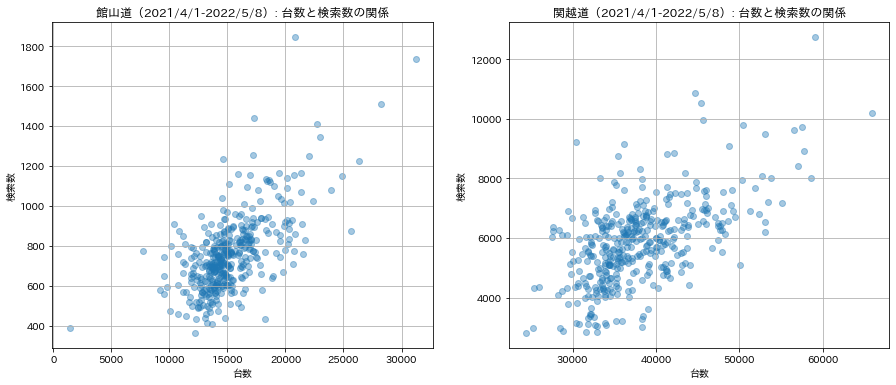

In [98]:
tat_sub = tat[(tat['start_name'] == '木更津ＪＣＴ') & (tat['end_name'] == '木更津南ＪＣＴ')]
kan_sub = kan[(kan['start_name'] == '東松山') & (kan['end_name'] == '嵐山小川')]

print('館山道: {:.3f}'.format(calc_corr(tat_sub, 'total', 'search')))
print('関越道: {:.3f}'.format(calc_corr(kan_sub, 'total', 'search')))

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].scatter(tat_sub['total'], tat_sub['search'], alpha=0.4)
axes[0].set_xlabel('台数')
axes[0].set_ylabel('検索数')
axes[0].set_title('館山道（2021/4/1-2022/5/8）: 台数と検索数の関係')
axes[0].grid()

axes[1].scatter(kan_sub['total'], kan_sub['search'], alpha=0.4)
axes[1].set_xlabel('台数')
axes[1].set_ylabel('検索数')
axes[1].set_title('関越道（2021/4/1-2022/5/8）: 台数と検索数の関係')
axes[1].grid()

plt.show()

#### 年間推移

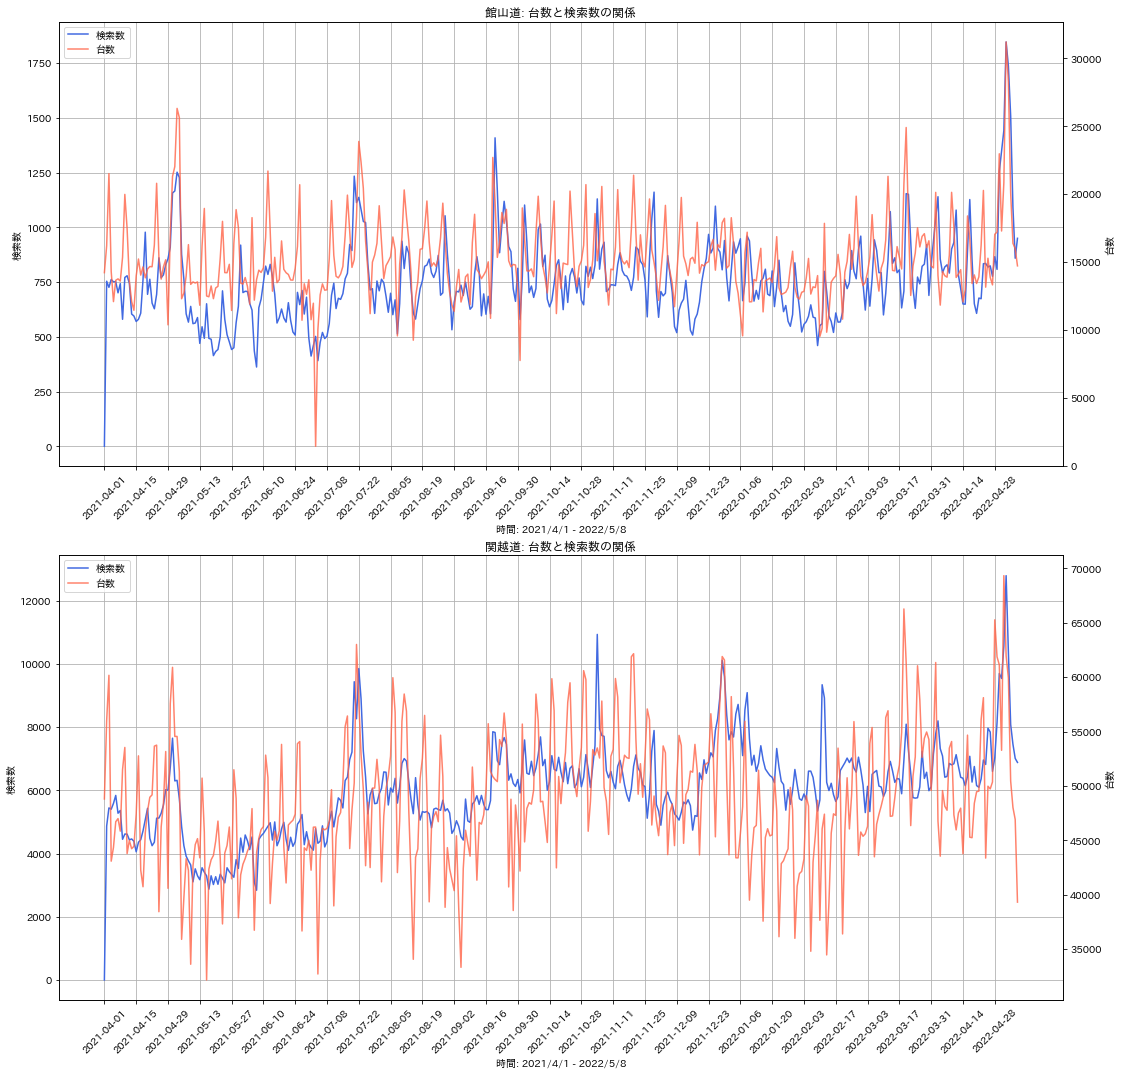

In [81]:
# tat_sub = tat[(tat['datetime'] >= pd.Timestamp('2022/4/29')) & (tat['datetime'] < pd.Timestamp('2022/5/9'))]
# kan_sub = kan[(kan['datetime'] >= pd.Timestamp('2022/4/29')) & (kan['datetime'] < pd.Timestamp('2022/5/9'))]
tat_sub = tat[(tat['start_name'] == '木更津ＪＣＴ') & (tat['end_name'] == '木更津南ＪＣＴ')]
kan_sub = kan[(kan['start_name'] == '鶴ヶ島ＪＣＴ') & (kan['end_name'] == '鶴ヶ島')]


fig, axes = plt.subplots(2, 1, figsize=(18, 18))
xs = range(len(tat_sub))
ticks = range(0, len(tat_sub), 14)
labels = tat_sub['datetime'].dt.date.iloc[ticks]

ax = axes[0]
ax2 = ax.twinx()
ax.plot(xs, tat_sub['search'], color='royalblue', label='検索数')
ax2.plot(xs, tat_sub['total'], color='tomato', label='台数', alpha=0.8)
ax.set_xlabel('時間: 2021/4/1 - 2022/5/8')
ax.set_ylabel('検索数')
ax2.set_ylabel('台数')
ax.set_title('館山道: 台数と検索数の関係')
ax.set_xticks(ticks=ticks, labels=labels, rotation=45)
ax.grid()

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)

ax = axes[1]
ax2 = ax.twinx()
ax.plot(xs, kan_sub['search'], color='royalblue', label='検索数')
ax2.plot(xs, kan_sub['total'], color='tomato', label='台数', alpha=0.8)

ax.set_xlabel('時間: 2021/4/1 - 2022/5/8')
ax.set_ylabel('検索数')
ax2.set_ylabel('台数')
ax.set_title('関越道: 台数と検索数の関係')
ax.set_xticks(ticks=ticks, labels=labels, rotation=45)
ax.grid()

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)

plt.show()

#### GW推移

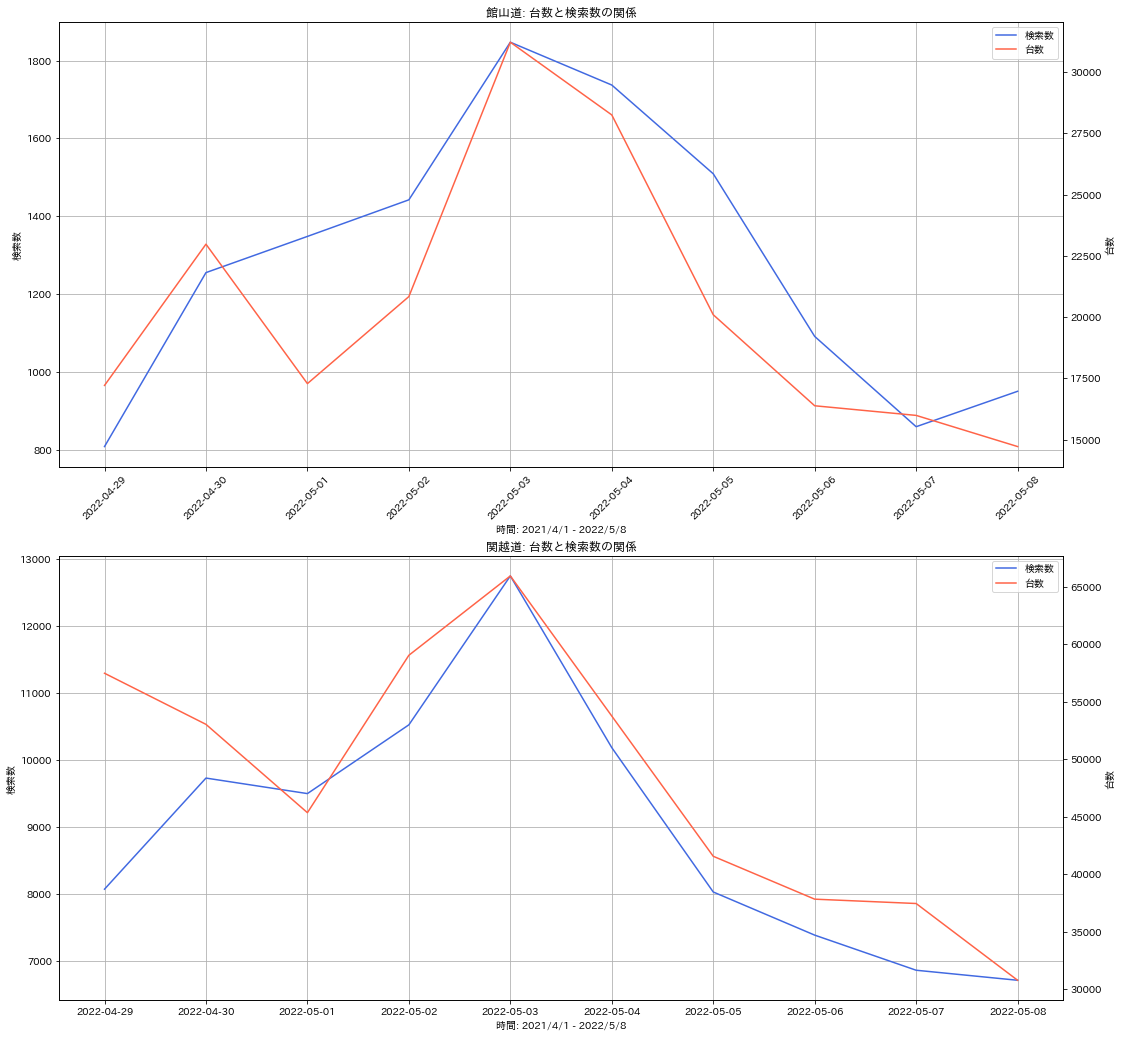

In [44]:
tat_sub = tat[(tat['datetime'] >= pd.Timestamp('2022/4/29')) & (tat['datetime'] < pd.Timestamp('2022/5/9'))]
kan_sub = kan[(kan['datetime'] >= pd.Timestamp('2022/4/29')) & (kan['datetime'] < pd.Timestamp('2022/5/9'))]
tat_sub = tat_sub[(tat_sub['start_name'] == '木更津ＪＣＴ') & (tat_sub['end_name'] == '木更津南ＪＣＴ')]
kan_sub = kan_sub[(kan_sub['start_name'] == '東松山') & (kan_sub['end_name'] == '嵐山小川')]


fig, axes = plt.subplots(2, 1, figsize=(18, 18))
xs = range(len(tat_sub))
ticks = range(len(tat_sub))
labels = tat_sub['datetime'].dt.date.iloc[ticks]

ax = axes[0]
ax2 = ax.twinx()
ax.plot(xs, tat_sub['search'], color='royalblue', label='検索数')
ax2.plot(xs, tat_sub['total'], color='tomato', label='台数')
ax.set_xlabel('時間: 2021/4/1 - 2022/5/8')
ax.set_ylabel('検索数')
ax2.set_ylabel('台数')
ax.set_title('館山道: 台数と検索数の関係')
ax.set_xticks(ticks=ticks, labels=labels, rotation=45)
ax.grid()

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)

ax = axes[1]
ax2 = ax.twinx()
ax.plot(xs, kan_sub['search'], color='royalblue', label='検索数')
ax2.plot(xs, kan_sub['total'], color='tomato', label='台数')

ax.set_xlabel('時間: 2021/4/1 - 2022/5/8')
ax.set_ylabel('検索数')
ax2.set_ylabel('台数')
ax.set_title('関越道: 台数と検索数の関係')
ax.set_xticks(ticks=ticks, labels=labels)
ax.grid()

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)

plt.show()

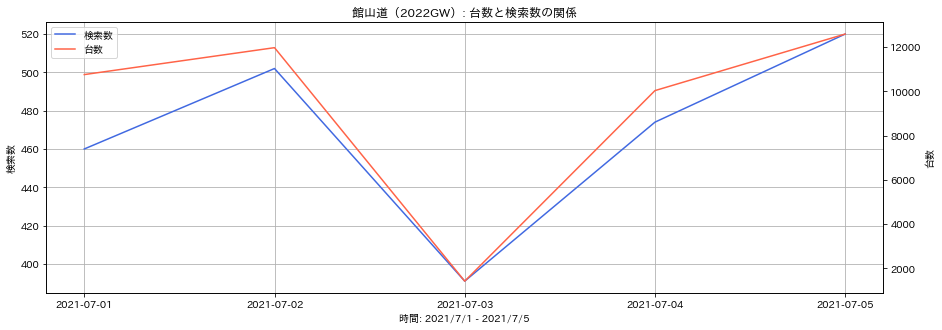

In [99]:
tmp = tat[(tat['datetime'] >= pd.Timestamp('2021/7/1')) & (tat['datetime'] < pd.Timestamp('2021/7/6'))]
tmp = tmp[(tmp['start_name'] == '木更津ＪＣＴ') & (tmp['end_name'] == '木更津南ＪＣＴ')]

xs = range(5)
ticks = range(5)
labels = tmp['datetime'].dt.date.unique()

fig, ax = plt.subplots(figsize=(15, 5))
ax2 = ax.twinx()
ax.plot(xs, tmp['search'], color='royalblue', label='検索数')
ax2.plot(xs, tmp['total'], color='tomato', label='台数')
ax.set_xlabel('時間: 2021/7/1 - 2021/7/5')
ax.set_ylabel('検索数')
ax2.set_ylabel('台数')
ax.set_title('館山道（2022GW）: 台数と検索数の関係')
ax.set_xticks(ticks=ticks, labels=labels)
ax.grid()

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)

plt.show()

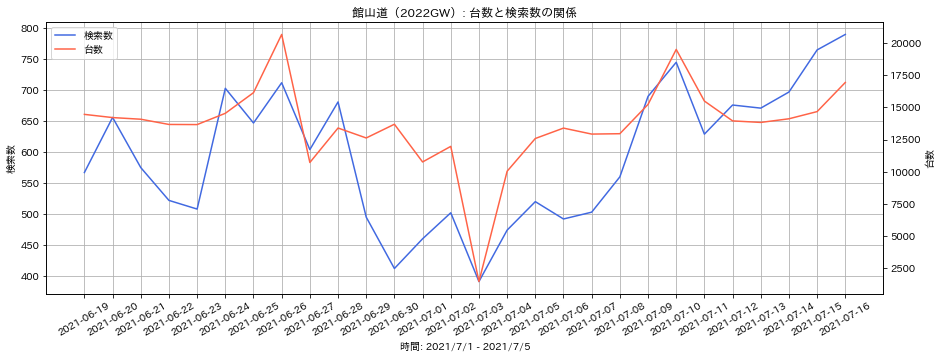

In [104]:
tmp = tat[(tat['datetime'] >= pd.Timestamp('2021/6/19')) & (tat['datetime'] < pd.Timestamp('2021/7/17'))]
tmp = tmp[(tmp['start_name'] == '木更津ＪＣＴ') & (tmp['end_name'] == '木更津南ＪＣＴ')]

xs = range(28)
ticks = range(28)
labels = tmp['datetime'].dt.date.unique()

fig, ax = plt.subplots(figsize=(15, 5))
ax2 = ax.twinx()
ax.plot(xs, tmp['search'], color='royalblue', label='検索数')
ax2.plot(xs, tmp['total'], color='tomato', label='台数')
ax.set_xlabel('時間: 2021/7/1 - 2021/7/5')
ax.set_ylabel('検索数')
ax2.set_ylabel('台数')
ax.set_title('館山道（2022GW）: 台数と検索数の関係')
ax.set_xticks(ticks=ticks, labels=labels, rotation=30)
ax.grid()

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)

plt.show()